In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
# - - - - - - - - - - - - - - - 
# Pressure interpolation 
# - - - - - - - - - - - - - - - 

def interpolateToPressure_v2(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [4]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
       
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()   

    return dsSel

def preprocess_h1(ds):
    
    keepVars = [
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
        
    return dsSel


def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw',
                      'edmf_precc','edmf_uplh',
                      'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})

    ## Replacing 'missing' updraft values with NaN 
    dsSel = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    dsSel = dsSel.load()

    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
    
    return dsSel

def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    dsSel = dsSel.load()
    
    return dsSel

def preprocessCLM_h0(ds):
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','pft'), QFLX)
    
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h2(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','landunit'), QFLX)
    
    dsSel = dsSel.load()

    return dsSel

In [5]:
# - - - - - - - - - - - - - - - 
# Additional processing after files are read in 
# - - - - - - - - - - - - - - - 

def process_camData(DS):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL',
                          'CONCLD','QT','GCLDLWP',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
        
    return DS


def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                           ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    return DS

def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                           ])
    
    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)
        
    return DS


In [6]:
def combineMacmic(ds_h3, ds_h2):
    var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

    var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
               'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

    varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
               'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

    for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

        varCyc1 = ds_h3[var1[iVar]]
        varCyc2 = ds_h3[var2[iVar]]

        ## This seems to work... 
        s = np.stack((varCyc1, varCyc2))
    #     C = np.nansum(s, axis=0)
        C = np.nanmean(s, axis=0)
        C[np.all(np.isnan(s), axis=0)] = np.nan

        ds_h2[varSave[iVar]]  = (('time','nens','levInterp'), np.squeeze(C))
    
    return ds_h2

In [7]:
# - - - - - - - - - - - - - - - 
# Plotting 
# - - - - - - - - - - - - - - - 

def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_h2.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_h2.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI_h2.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI_h2.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig


def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax


In [103]:
def plotTimeHeight_h2_caseMean(days1_ds, days2_ds, days3_ds, 
                               homCaseName, hetCaseName,
                               varToPlot, strTitles, 
                               cbarArr_mean, cbarArr_diff,
                               weight=True): 
    
    if weight==True:
        HOMwgts_day1 = days1_ds.upa_macmicAvg_interp.sel(case=homCaseName).fillna(0)
        HETwgts_day1 = days1_ds.upa_macmicAvg_interp.sel(case=hetCaseName).fillna(0)
        HOMmean_day1 = days1_ds[varToPlot].sel(case=homCaseName).weighted(HOMwgts_day1).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
        HETmean_day1 = days1_ds[varToPlot].sel(case=hetCaseName).weighted(HETwgts_day1).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

        HOMwgts_day2 = days2_ds.upa_macmicAvg_interp.sel(case=homCaseName).fillna(0)
        HETwgts_day2 = days2_ds.upa_macmicAvg_interp.sel(case=hetCaseName).fillna(0)
        HOMmean_day2 = days2_ds[varToPlot].sel(case=homCaseName).weighted(HOMwgts_day2).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
        HETmean_day2 = days2_ds[varToPlot].sel(case=hetCaseName).weighted(HETwgts_day2).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

        HOMwgts_day3 = days3_ds.upa_macmicAvg_interp.sel(case=homCaseName).fillna(0)
        HETwgts_day3 = days3_ds.upa_macmicAvg_interp.sel(case=hetCaseName).fillna(0)
        HOMmean_day3 = days3_ds[varToPlot].sel(case=homCaseName).weighted(HOMwgts_day3).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
        HETmean_day3 = days3_ds[varToPlot].sel(case=hetCaseName).weighted(HETwgts_day3).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

    else:
#         HOMmean_day1 = days1_ds[varToPlot].sel(case='clubbMF_L0eq250').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
#         HETmean_day1 = days1_ds[varToPlot].sel(case='claspMF_L0eq250').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

#         HOMmean_day2 = days2_ds[varToPlot].sel(case='clubbMF_L0eq250').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
#         HETmean_day2 = days2_ds[varToPlot].sel(case='claspMF_L0eq250').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

#         HOMmean_day3 = days3_ds[varToPlot].sel(case='clubbMF_L0eq250').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
#         HETmean_day3 = days3_ds[varToPlot].sel(case='claspMF_L0eq250').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

        HOMmean_day1 = days1_ds[varToPlot].sel(case=homCaseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
        HETmean_day1 = days1_ds[varToPlot].sel(case=hetCaseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')

        HOMmean_day2 = days2_ds[varToPlot].sel(case=homCaseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
        HETmean_day2 = days2_ds[varToPlot].sel(case=hetCaseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')

        HOMmean_day3 = days3_ds[varToPlot].sel(case=homCaseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
        HETmean_day3 = days3_ds[varToPlot].sel(case=hetCaseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')

    
    ## ----- Plot that ----- 
    fig,axs = plt.subplots(3,3, figsize=(15,15))
    axs = axs.ravel()

    
    ## Plot overall means (first case of days) 
    axs[0].contourf(HOMmean_day1.hour.values, HOMmean_day1.levInterp.values, 
                    HOMmean_day1.values.transpose(), cbarArr_mean, 
                    cmap = 'plasma', extend='both')
    axs[0].set_title('Mean '+varToPlot+': HOM case'+strTitles[0])

    cplot = axs[1].contourf(HETmean_day1.hour.values, HETmean_day1.levInterp.values, 
                    HETmean_day1.values.transpose(), cbarArr_mean, 
                    cmap = 'plasma', extend='both')
    axs[1].set_title('Mean '+varToPlot+': HET case'+strTitles[0])

    cplot = axs[2].contourf(HETmean_day1.hour.values, HETmean_day1.levInterp.values, 
                HETmean_day1.values.transpose()-HOMmean_day1.values.transpose(), 
                cbarArr_diff, 
                cmap = 'seismic', extend='both')
    axs[2].set_title('HET-HOM')
    
    if weight==True:
        ## Add significance testing 
        diffCases = HETmean_day1-HOMmean_day1
        levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                            len(diffCases.levInterp.values), varToPlot,   homCaseName, hetCaseName, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[2].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)
    else: 
        ## Add significance testing 
        diffCases = HETmean_day1-HOMmean_day1
        levSig    = getStatSigCI(len(diffCases.hour.values), 
                            len(diffCases.levInterp.values), varToPlot,   homCaseName, hetCaseName, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[2].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)

        
        
        
    ## Plot overall means (second case of days) 
    axs[3].contourf(HOMmean_day2.hour.values, HOMmean_day2.levInterp.values, 
                    HOMmean_day2.values.transpose(), cbarArr_mean, 
                    cmap = 'plasma', extend='both')
    axs[3].set_title('Mean '+varToPlot+': HOM case'+strTitles[1])

    cplot = axs[4].contourf(HETmean_day2.hour.values, HETmean_day2.levInterp.values, 
                    HETmean_day2.values.transpose(), cbarArr_mean, 
                    cmap = 'plasma', extend='both')
    axs[4].set_title('Mean '+varToPlot+': HET case'+strTitles[1])

    cplot = axs[5].contourf(HETmean_day1.hour.values, HETmean_day1.levInterp.values, 
                HETmean_day2.values.transpose()-HOMmean_day2.values.transpose(), 
                cbarArr_diff, 
                cmap = 'seismic', extend='both')
    axs[5].set_title('HET-HOM')
    
    if weight==True:
        ## Add significance testing 
        diffCases = HETmean_day1-HOMmean_day1
        levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                            len(diffCases.levInterp.values), varToPlot,   homCaseName, hetCaseName, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[5].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)
    else: 
        ## Add significance testing 
        diffCases = HETmean_day1-HOMmean_day1
        levSig    = getStatSigCI(len(diffCases.hour.values), 
                            len(diffCases.levInterp.values), varToPlot,   homCaseName, hetCaseName, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[5].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)
    
    
    
    ## Plot overall means (third case of days) 
    axs[6].contourf(HOMmean_day3.hour.values, HOMmean_day3.levInterp.values, 
                    HOMmean_day3.values.transpose(), cbarArr_mean, 
                    cmap = 'plasma', extend='both')
    axs[6].set_title('Mean '+varToPlot+': HOM case'+strTitles[2])

    cplot = axs[7].contourf(HETmean_day3.hour.values, HETmean_day3.levInterp.values, 
                    HETmean_day3.values.transpose(), cbarArr_mean, 
                    cmap = 'plasma', extend='both')
    axs[7].set_title('Mean '+varToPlot+': HET case'+strTitles[2])
    # add colorbar for overall mean cases 
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.05, ax_position.width+0.06, 0.01])
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

    cplot = axs[8].contourf(HETmean_day3.hour.values, HETmean_day3.levInterp.values, 
                HETmean_day3.values.transpose()-HOMmean_day3.values.transpose(), 
                cbarArr_diff, 
                cmap = 'seismic', extend='both')
    axs[8].set_title('HET-HOM')    
    # add colorbar for differences
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.01])
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax, label='m/s')

    if weight==True:
        ## Add significance testing 
        diffCases = HETmean_day1-HOMmean_day1
        levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                            len(diffCases.levInterp.values), varToPlot,   homCaseName, hetCaseName, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[8].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)
    else: 
        ## Add significance testing 
        diffCases = HETmean_day1-HOMmean_day1
        levSig    = getStatSigCI(len(diffCases.hour.values), 
                            len(diffCases.levInterp.values), varToPlot,   homCaseName, hetCaseName, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[8].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)
                    
    
    ## Other plot options 
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([980,500])
    axs[1].set_ylim([980,500])
    axs[2].set_ylim([980,500])
    axs[3].set_ylim([980,500])
    axs[4].set_ylim([980,500])
    axs[5].set_ylim([980,500])
    axs[6].set_ylim([980,500])
    axs[7].set_ylim([980,500])
    axs[8].set_ylim([980,500])
    
    axs[6].set_xlabel('Local Hour')
    axs[7].set_xlabel('Local Hour')
    axs[8].set_xlabel('Local Hour')

    axs[0].set_ylabel('hPa')
    axs[3].set_ylabel('hPa')
    axs[6].set_ylabel('hPa')
    
    return

In [104]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

## Read in data

In [9]:
testDir     = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/'

case_names  = [
#                'clubbMF_L0eq50',
#                'claspMF_L0eq50',
    
               'clubbMF_L0eq250',
               # 'claspMF_L0eq250',
               # 'claspMF_L0eq250_52pct',
               'claspMF_L0eq250_rand',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
            # 'usePatchDataFALSE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq50_nup25_LUbased_allJJA.',
            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq50_nup25_LUbased_allJJA', # Pass LU means, don't calculate after the fact

            'usePatchDataFALSE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq250_nup25_LUbased_allJJA.',
            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq250_nup25_LUbased_allJJA.', # Pass LU means, don't calculate after the fact
            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_nup25_LUbased_52pctWarmest_allJJA.',
            'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_nup25_LUbased_randomAllocPlumes05_allJJA.', #Random allocation 
]

countCLMh2 = 0 

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0.2015*'))
    listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1.2015*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2.2015*'))
    listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3.2015*'))

    listFilesCLM_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h2.2015*'))
    listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1.2015*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0.2015*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 2D data loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
    # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    
    caseH2   = xr.merge([case_h2, case_h2_2d])
    caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    
    caseH3   = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3   = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})
    del case_h0,case_h1,case_h2,case_h2_2d,case_h3

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    del caseFull
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    del caseH2
    procDS_h3 = process_camData_h3( caseH3, procDS  )
    del caseH3
    
    procDS_h2 = combineMacmic(procDS_h3, procDS_h2)
    del procDS_h3
            
    ## Combine all the cases into 
    case_allDays      = procDS.squeeze().assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.squeeze().assign_coords({"case":  case_names[iCase]})
    # h3_allDays        = procDS_h3.squeeze().assign_coords({"case":  case_names[iCase]})
                        
    if iCase==0:
        scamDS    = case_allDays
        del case_allDays
        scamDS_h2 = h2_allDays
        del h2_allDays
        # scamDS_h3 = h3_allDays
        # del h3_allDays
    else: 
        scamDS    = xr.concat([scamDS, case_allDays], "case") 
        del case_allDays
        scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
        del h2_allDays
        # scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 
        # del h3_allDays
            
    ## Read in CLM datasets too 
 
 #    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')
    
    clm2_exists = False
    if len(listFilesCLM_h2)>0:
        caseCLM_h2 = xr.open_mfdataset(listFilesCLM_h2,  preprocess=preprocessCLM_h2, concat_dim='time', 
                                    combine='nested', decode_times=True, 
                                    data_vars='minimal')
        caseCLMh2_allDays = caseCLM_h2.assign_coords({"case":  case_names[iCase]})
        clm2_exists = True
        print('CLM_h2 files loaded with mfdataset')

#     caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
#         clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
        # if len(listFilesCLM_h2)>0:
        #     clmDS_h2 = caseCLMh2_allDays
        #     del caseCLMh2_allDays
    else: 
#         clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
        # if len(listFilesCLM_h2)>0:
        #     clmDS_h2 = xr.concat([clmDS_h2, caseCLMh2_allDays], "case") 
        #     del caseCLMh2_allDays
                    
    if clm2_exists==True: 
        if countCLMh2==0:
            clmDS_h2 = caseCLMh2_allDays
            countCLMh2 = countCLMh2+1
        else: 
            clmDS_h2 = xr.concat([clmDS_h2, caseCLMh2_allDays], "case") 
            countCLMh2 = countCLMh2+1
        
    del caseCLMh1_allDays
    print('Done with CLM files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
        

*** Starting on case clubbMF_L0eq250 ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h1 files loaded with mfdataset
CLM_h2 files loaded with mfdataset
Done with CLM files
Done with case 1 of 2 
*** Starting on case claspMF_L0eq250_rand ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h1 files loaded with mfdataset
CLM_h2 files loaded with mfdataset
Done with CLM files
Done with case 2 of 2 


In [10]:
plumeLabel = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values), len(scamDS_h2.nens.values)], 'SurfaceAvg')

sigDig     = 9

for iCase in range(len(clmDS_h2.case.values)):

    for iT in range(len(clmDS_h1.time.values)-1):

        # Sel time QFLX and edmf_uplh 
        this_uplh    = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_uplh.values
        this_qflx    = clmDS_h1.isel(case=(iCase)).isel(time=iT).QFLX 
        this_qflx_LU = clmDS_h2.isel(case=iCase).isel(time=iT).QFLX 
        this_upa     = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values

        iGrass = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[0],sigDig))[0]
        iCrop  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[1],sigDig))[0]

        # Land-unit means...
        iUrban = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[2],sigDig))[0]
        iLake  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[3],sigDig))[0]
        
        ## TODO: For safety, since using a round off digit, should confirm that things aren't being marked as two PFTs 

        ## Also fill in if the plume is not active...
        this_upa  = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values
        iMiss     = np.where(this_upa==0.0)[0]

        plumeLabel[iCase, iT, iGrass] = 'C3grass'
        plumeLabel[iCase, iT, iCrop]  = 'IrrigCrop'
        plumeLabel[iCase, iT, iLake]  = 'Lake'
        plumeLabel[iCase, iT, iUrban] = 'Urban'
        plumeLabel[iCase, iT, iMiss]  = 'Off'

        # if iCase==0: 
        #     ## Also fill in if the plume is not active in HOM case
        #     this_upa  = scamDS_h2.sel(case='clubbMF_L0eq250').isel(time=iT, ilev=-1).edmf_upa.values
        #     iMiss2    = np.where(this_upa==0.0)[0]
        #     plumeLabel[0, iT, iMiss2]  = 'Off'

scamDS_h2['plumeLabel'] = (('case','time','nens'), plumeLabel)


In [11]:
print('Just testing out to see what labels look... ')
iselTime = 200
print(scamDS_h2.time.values[iselTime])
print(scamDS_h2.case.values[0], ': ',scamDS_h2['plumeLabel'].isel(case=0).isel(time=iselTime).values)
print(scamDS_h2.case.values[1], ': ',scamDS_h2['plumeLabel'].isel(case=1).isel(time=iselTime).values)


Just testing out to see what labels look... 
2015-06-02T16:43:30.000000000
clubbMF_L0eq250 :  ['SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg'
 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg'
 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg'
 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg'
 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg' 'SurfaceAvg']
claspMF_L0eq250_rand :  ['C3grass' 'C3grass' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop'
 'IrrigCrop' 'IrrigCrop' 'Lake' 'Lake' 'Lake' 'Lake' 'Lake' 'Lake' 'Lake'
 'Lake' 'Lake' 'Lake' 'Urban' 'Urban' 'Urban' 'Urban' 'Urban' 'Urban'
 'Urban']


In [12]:
## Get number of plumes at each time/level
nPlumesActive = scamDS_h2.thlu_macmicAvg_interp.count(dim='nens')
print(np.shape(nPlumesActive))

scamDS['nPlumesActive'] = (('case','time','levInterp'), nPlumesActive)

for iCase in range(len(scamDS_h2.case.values)):

    grassDS = scamDS_h2.where(scamDS_h2.plumeLabel == 'C3grass')
    cropDS  = scamDS_h2.where(scamDS_h2.plumeLabel == 'IrrigCrop')
    lakeDS  = scamDS_h2.where(scamDS_h2.plumeLabel == 'Lake')
    urbanDS = scamDS_h2.where(scamDS_h2.plumeLabel == 'Urban')

scamDS['nPlumesActive_grass'] = (('case','time','levInterp'), grassDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_crop']  = (('case','time','levInterp'), cropDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_urban'] = (('case','time','levInterp'), urbanDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_lake']  = (('case','time','levInterp'), lakeDS.thlu_macmicAvg_interp.count(dim='nens'))



(2, 26496, 78)


In [13]:
tot_wp2 = scamDS_h2.edmf_S_AWW_interp.values + scamDS.WP2_CLUBB_interp.values
scamDS_h2['total_wp2']  = (('case','time','levInterp'), tot_wp2)

tot_thlp2 = scamDS_h2.edmf_S_ATHLTHL_interp.values + scamDS.THLP2_CLUBB_interp.values
scamDS_h2['total_thlp2']  = (('case','time','levInterp'), tot_thlp2)

tot_rtp2 = scamDS_h2.edmf_S_AQTQT_interp.values + (1e-6 * scamDS.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
scamDS_h2['total_rtp2']  = (('case','time','levInterp'), tot_rtp2)

tot_wpthlp = scamDS_h2.edmf_thlflxup_interp.values + (scamDS.wpthlp_interp.values)
scamDS_h2['total_wpthlp']  = (('case','time','levInterp'), tot_wpthlp)

tot_wprtp = scamDS_h2.edmf_qtflxup_interp.values + (scamDS.wprtp_interp.values)
scamDS_h2['total_wprtp']  = (('case','time','levInterp'), tot_wprtp)



In [14]:
del tot_wp2,tot_thlp2,tot_rtp2,tot_wprtp,nPlumesActive,plumeLabel

## Group all days together

**Timeseries?**

In [114]:
scamDS[pltVar]

<xarray.DataArray 'PRECC' (case: 2, time: 26496)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
  * time     (time) datetime64[ns] 2015-06-02T00:03:30 ... 2015-09-01T23:58:30
  * case     (case) object 'clubbMF_L0eq250' 'claspMF_L0eq250_rand'
Attributes:
    units:         m/s
    long_name:     Convective precipitation rate (liq + ice)
    cell_methods:  time: mean

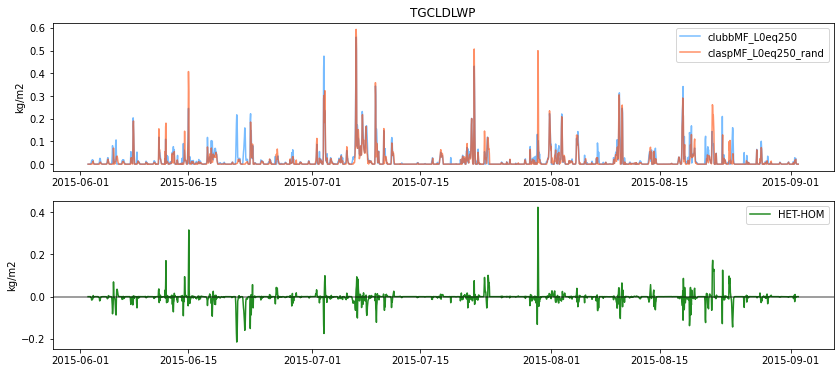

In [142]:
pltVar = 'TGCLDLWP'

ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'

fig,axs=plt.subplots(2,1,figsize=(14,6))
axs.ravel()

ctrlVar = scamDS[pltVar].sel(case=ctrlCase).resample(time='1H').mean(dim='time')
testVar = scamDS[pltVar].sel(case=testCase).resample(time='1H').mean(dim='time')

axs[0].plot(ctrlVar.time.values, ctrlVar.values, color='dodgerblue', label=ctrlCase, alpha=0.6)
axs[0].plot(testVar.time.values, testVar.values, color='orangered', label=testCase, alpha=0.6)
axs[0].legend()
axs[0].set_title(pltVar)
axs[0].set_ylabel(scamDS[pltVar].units)

axs[1].plot(testVar.time.values, testVar.values-ctrlVar.values, 
            color='forestgreen', label='HET-HOM', alpha=1)
axs[1].legend()
axs[1].set_ylabel(scamDS[pltVar].units)
axs[1].axhline(0,color='k',alpha=0.5)



In [15]:
# Limit to daytime hours
selHours = np.where((scamDS['time.hour'].values>=7) & (scamDS['time.hour'].values<=19))[0]
scamDaytime  = scamDS.isel(time=selHours)


In [16]:
scamRain  = scamDaytime.PRECC.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,
# scamRain  = scamDaytime.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,
# scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF_L0eq250').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='claspMF_L0eq250_rand').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]

# rainRatesHTGrand_scam = scamRain.sel(case='claspMF_L0eq250_rand').values
# rainRatesHTGrand_scam = rainRatesHTGrand_scam[np.where(rainRatesHTGrand_scam>0)[0]]


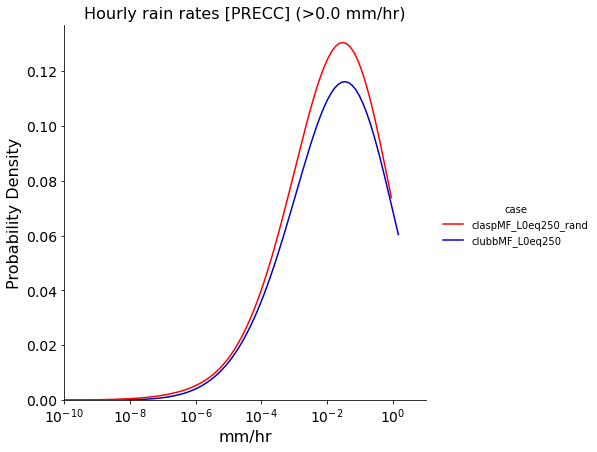

In [17]:
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTGrand_scam), 'case': 'claspMF_rand'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'claspMF_L0eq250_rand'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'clubbMF_L0eq250'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['red','mediumblue'], legend=True)

g.ax.set_xlim([10**-10, 10**1])
g.ax.set_title("Hourly rain rates [PRECC] (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)


[None, None, None, None]

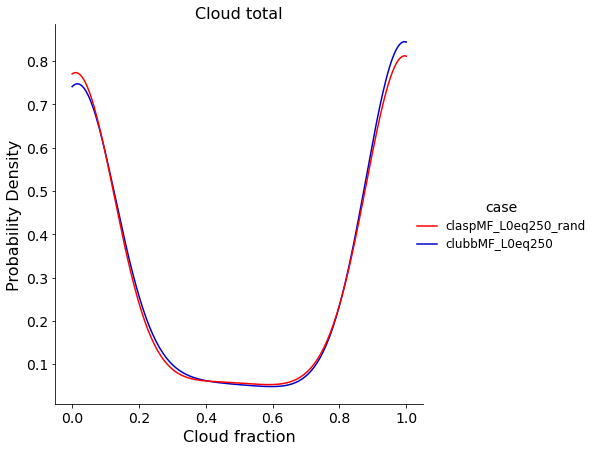

In [18]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDaytime.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# # Limit to daytime hours
# selHours = np.where(scamCLD['time.hour'].values<=19)[0]
# scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF_L0eq250').values
cldHTG_scam = scamCLD.sel(case='claspMF_L0eq250_rand').values
# cldHTGrand_scam = scamCLD.sel(case='claspMF_L0eq250_rand').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTGrand_scam), 'case': 'claspMF_rand'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTG_scam), 'case': 'claspMF_L0eq250_rand'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHMG_scam), 'case': 'clubbMF_L0eq250'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Cloud Fraction', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("Cloud total", fontsize=16 ) 
g.ax.set_xlabel('Cloud fraction',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


[None, None, None, None]

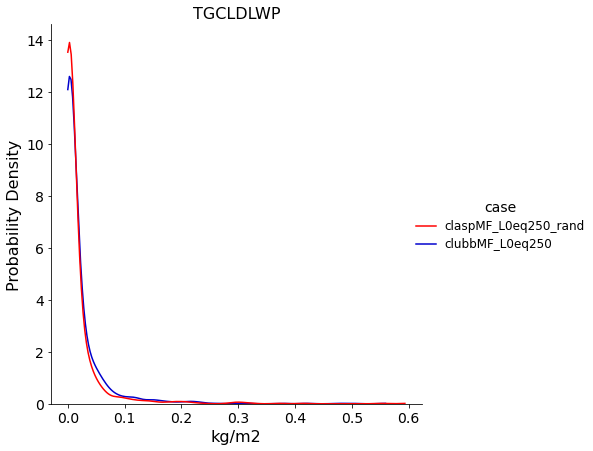

In [20]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDaytime.TGCLDLWP.resample(time='1H').mean().dropna(dim='time')
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# # Limit to daytime hours
# selHours = np.where(scamCLD['time.hour'].values<=19)[0]
# scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF_L0eq250').values
cldHTG_scam = scamCLD.sel(case='claspMF_L0eq250_rand').values
# cldHTGrand_scam = scamCLD.sel(case='claspMF_L0eq250_rand').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTGrand_scam), 'case': 'claspMF_rand'}),
         pd.DataFrame.from_dict({'TGCLDLWP': np.squeeze(cldHTG_scam), 'case': 'claspMF_L0eq250_rand'}),
         pd.DataFrame.from_dict({'TGCLDLWP': np.squeeze(cldHMG_scam), 'case': 'clubbMF_L0eq250'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='TGCLDLWP', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("TGCLDLWP", fontsize=16 ) 
g.ax.set_xlabel('kg/m2',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


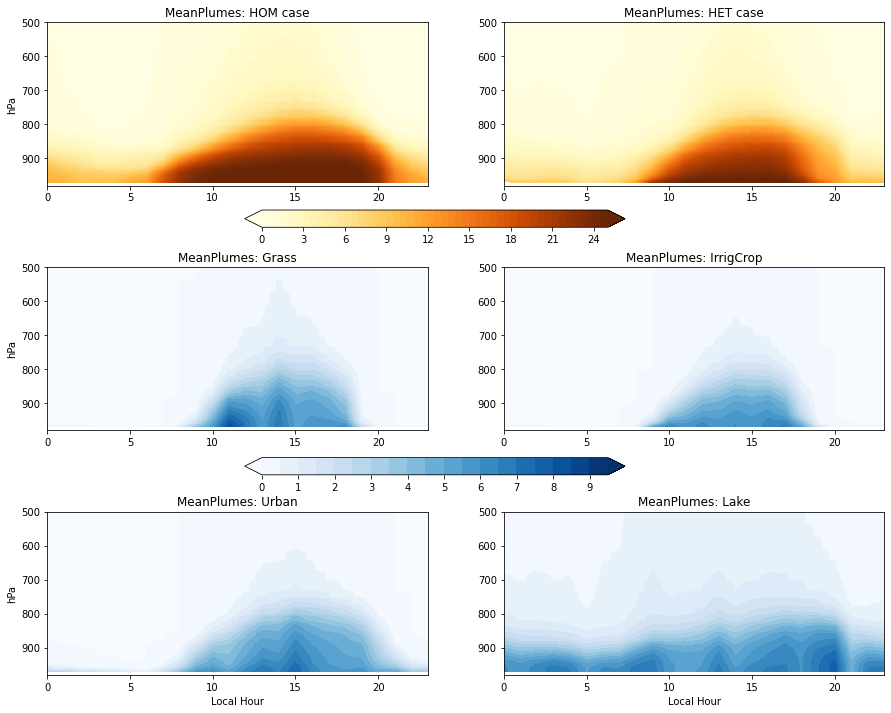

In [21]:
## Look at diurnal cycle of plume initiations?
nplumes_grassMean  = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_grass.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_cropMean   = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_crop.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_urban.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_lake.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = scamDS.sel(case='clubbMF_L0eq250').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,25.5,0.5), 
                cmap = 'YlOrBr', extend='both')
axs[0].set_title('MeanPlumes: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,25.5,0.5), 
                cmap = 'YlOrBr', extend='both')
axs[1].set_title('MeanPlumes: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,10,0.5), 
                cmap = 'Blues', extend='both')
axs[2].set_title('MeanPlumes: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,10,0.5), 
                cmap = 'Blues', extend='both')
axs[3].set_title('MeanPlumes: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,10,0.5), 
                cmap = 'Blues', extend='both')
axs[4].set_title('MeanPlumes: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,10,0.5), 
                cmap = 'Blues', extend='both')
axs[5].set_title('MeanPlumes: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

fig.subplots_adjust(hspace = 0.5)


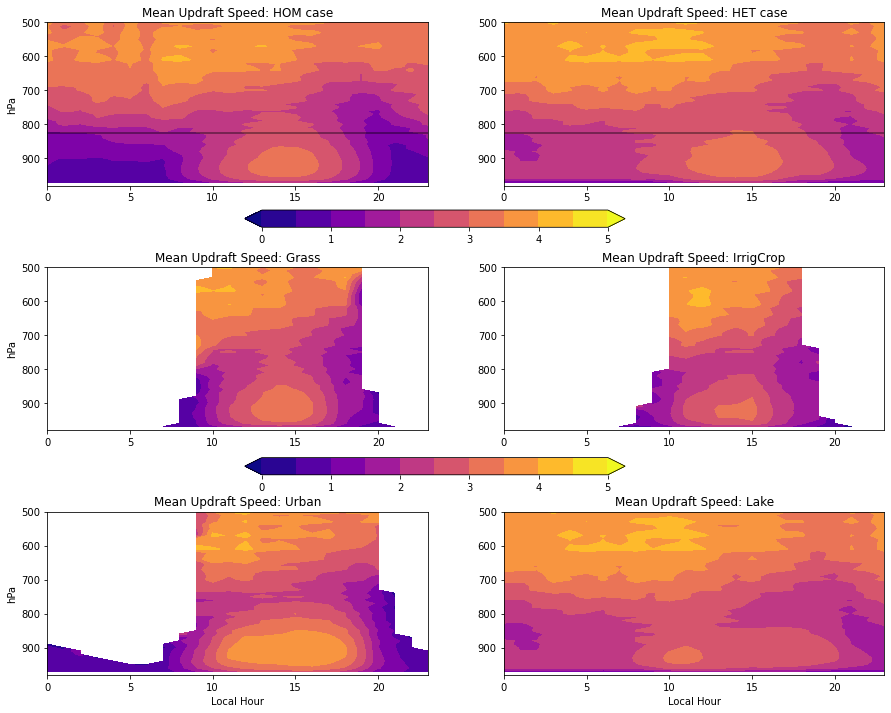

In [22]:
# varToPlot = 'edmf_upw_interp'
varToPlot = 'up_macmicAvg_interp'

# Look at diurnal cycle of plume initiations?
nplumes_grassMean  = grassDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(grassDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = cropDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(cropDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = urbanDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(urbanDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = lakeDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(lakeDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_L0eq250_rand').fillna(0)
nplumes_HOMmean    = scamDS_h2[varToPlot].sel(case='clubbMF_L0eq250').weighted(HOMwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS_h2[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(HETwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[0].set_title('Mean Updraft Speed: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[1].set_title('Mean Updraft Speed: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[2].set_title('Mean Updraft Speed: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[3].set_title('Mean Updraft Speed: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[4].set_title('Mean Updraft Speed: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[5].set_title('Mean Updraft Speed: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

# axs[0].set_xlim([7,19])
# axs[1].set_xlim([7,19])
# axs[2].set_xlim([7,19])
# axs[3].set_xlim([7,19])
# axs[4].set_xlim([7,19])
# axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

axs[0].axhline(825,color='k',alpha=0.5)
axs[1].axhline(825,color='k',alpha=0.5)

fig.subplots_adjust(hspace = 0.5)


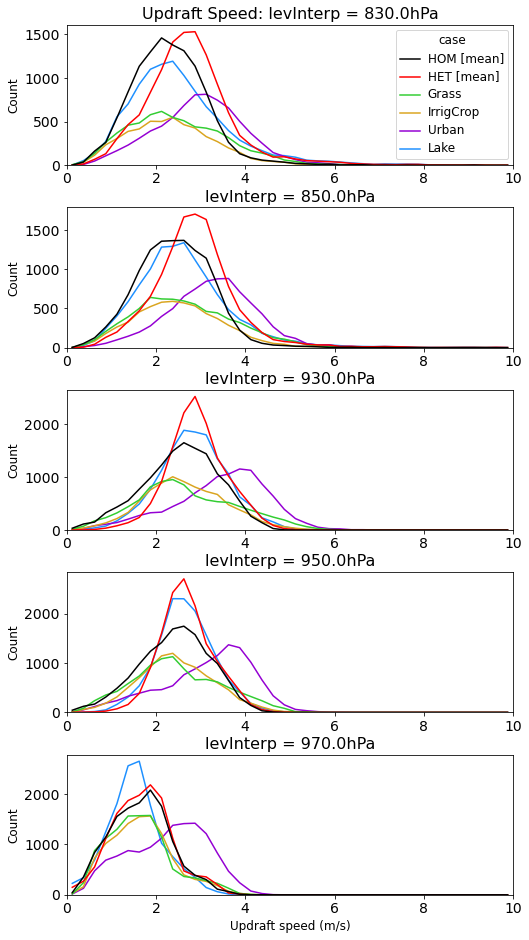

In [23]:
## Data choices 

varSel = 'up_macmicAvg_interp'
# levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]
levSel = [-15,-13,-5,-3,-1]

# Limit to daytime hours
selHours = np.where((scamDS_h2['time.hour'].values>=7) & (scamDS_h2['time.hour'].values<=19))[0]
# scamDay  = scamDS_h2.isel(time=selHours).mean(dim='nens')

edmf_grass = grassDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(grassDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
edmf_crop  = cropDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(cropDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
edmf_urban  = urbanDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(urbanDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
edmf_lake   = lakeDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(lakeDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').isel(time=selHours).fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_L0eq250_rand').isel(time=selHours).fillna(0)
edmf_CTRL  = scamDS_h2[varSel].sel(case='clubbMF_L0eq250').isel(time=selHours).weighted(HOMwgts).mean(dim='nens')
edmf_HET   = scamDS_h2[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(HETwgts).mean(dim='nens')


fig, axes = plt.subplots(5,1, figsize=(8,16))

## Make figures 
for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_CTRL.isel(levInterp=levSel[ilev]).values), 'case': 'HOM [mean]'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_HET.isel(levInterp=levSel[ilev]).values), 'case': 'HET [mean]'}),

        pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_grass.isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_crop.isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_urban.isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_lake.isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])


    if ilev==0:
        # g = sns.kdeplot( data=dfReal, x='UpdraftSpeed', hue='case', cut=0,
        # #                 fill=True, alpha=0.5,
        #                 common_norm = True,
        #                 palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
        #                 # palette=['k','red'],
        #                # height=3, aspect=9/3, 
        #                ax = axes[ilev]
        #                )
        g = sns.histplot( data=dfReal, x='UpdraftSpeed', hue='case',
                         stat = 'count',
                         binwidth=0.25,
                         binrange=[0,10],
                         element='poly',
                         fill=False,
                        palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                        # palette=['k','red','limegreen','dodgerblue'],
                       # height=3, aspect=9/3, 
                       ax = axes[ilev]
                       )
    else:
        g = sns.histplot( data=dfReal, x='UpdraftSpeed', hue='case',
                         stat = 'count',
                         binwidth=0.25,
                         binrange=[0,10],
                         element='poly',
                         fill=False,
                         legend=False,
                        palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                        # palette=['k','red','limegreen','dodgerblue'],
                       # height=3, aspect=9/3, 
                       ax = axes[ilev],
                       )
        
        
    if ilev==0:
        axes[ilev].set_title("Updraft Speed: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]])+'hPa', fontsize=16 )
        plt.setp(g.legend_.get_title(), fontsize=12)
        plt.setp(g.legend_.get_texts(), fontsize=12)
    else:
        axes[ilev].set_title("levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]])+'hPa', fontsize=16 ) 

        
    if ilev==len(levSel)-1:
        axes[ilev].set_xlabel('Updraft speed (m/s)',fontsize=12)
    else:
        axes[ilev].set_xlabel('')
        
    # axes[ilev].set_ylabel('Probability Density',fontsize=12)
    axes[ilev].set_ylabel('Count',fontsize=12)
    axes[ilev].set_xlim([0.00, 10])
    # axes[ilev].set_ylim([0.0, 0.45])

    axes[ilev].tick_params(axis='both', labelsize= 14)



fig.subplots_adjust(hspace=0.3)

In [24]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)

# hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h2 = clmDS_h2.groupby('time.hour').mean(dim='time')



In [25]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2


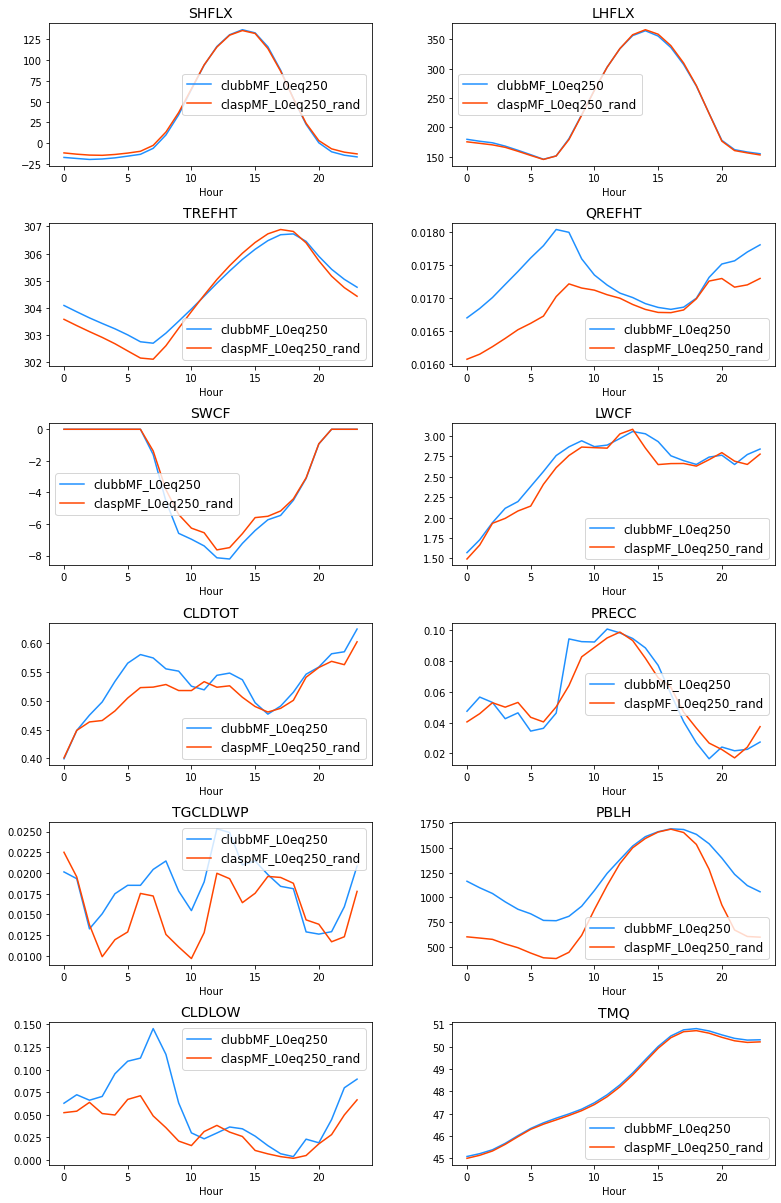

In [26]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECC',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    if pltVars[iPlt]=='PRECC': 
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 color='dodgerblue', label=ctrlCase)
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 color='orangered', label=testCase)   
    else: 
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
                 color='orangered', label=testCase)
    

    axs[iPlt].legend(fontsize=12,)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


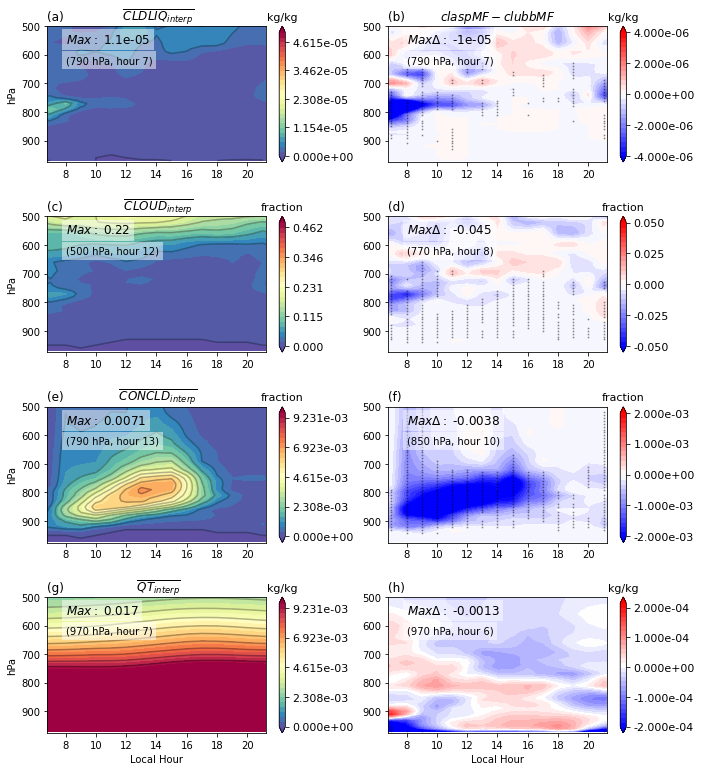

In [27]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.01,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 500

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'


# ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
# testDS    = hourlyMeanSCAM.sel(case=testCase)
# diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        


In [28]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase, CIlevel): 

    ## Get ranges for each case's CI 
    CI_h2_ctrl           = CIlevel*hourlySE_h2.sel(case=ctrlCase)[varSel]
    CI_h2_test           = CIlevel*hourlySE_h2.sel(case=testCase)[varSel]

#     ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], -CI_h2_ctrl], axis=0)
#     testDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], -CI_h2_test], axis=0)

#     ctrlDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], CI_h2_ctrl], axis=0)
#     testDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], CI_h2_test], axis=0)

    ctrlDS_lowCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase)[varSel] -CI_h2_ctrl
    testDS_lowCI    = hourlyMeanSCAM_h2.sel(case=testCase)[varSel] -CI_h2_test

    ctrlDS_hghCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase)[varSel] + CI_h2_ctrl
    testDS_hghCI    = hourlyMeanSCAM_h2.sel(case=testCase)[varSel] + CI_h2_test



    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

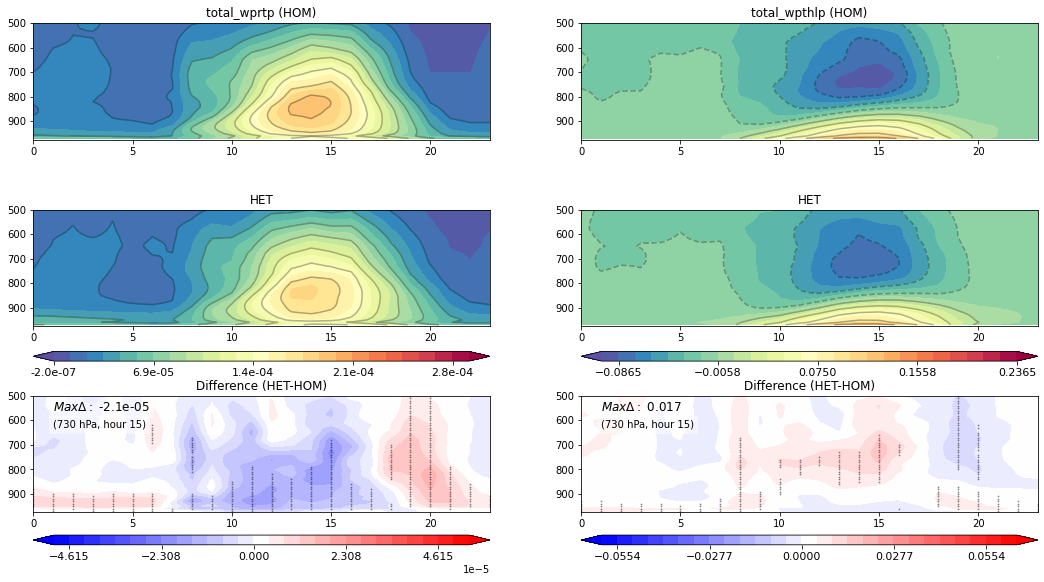

In [29]:
ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'
# testCase = 'claspMF_L0eq250_rand'

pltVars  = [
            'total_wprtp',
            'total_wpthlp',
            # 'edmf_qtflxup_interp',
            # 'edmf_thlflxup_interp', 
            ]

cMin    = [
          -2e-7, 
           -0.1,
          ]

cMax    = [
           3e-4,
           0.25,
          ]

diffMax = [
           5.0e-5,
           0.06,
          ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
        ]

fig,axs = plt.subplots(3, len(pltVars), figsize=(18,9))
axs     = axs.ravel()

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 

        # - - - - Plot control case - - - -
        cplt = axs[iVar].contourf(ctrlDS['hour'].values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')

        # Add contour lines
        cplt = axs[iVar].contour(ctrlDS['hour'].values, ctrlDS.levInterp.values, 
                        np.squeeze(ctrlDS[pltVars[iVar]].values).transpose(),
                        np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )

        axs[iVar].set_title(pltVars[iVar]+' (HOM)')


        # - - - - Plot CLASP case - - - -
        cplt = axs[iVar+len(pltVars)].contourf(testDS['hour'].values, testDS.levInterp.values, 
                       np.squeeze(testDS[pltVars[iVar]].values).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
        ax_position = axs[iVar+len(pltVars)].get_position()
#             cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.038, ax_position.width+0.15, 0.015])
        if pltVars[iVar]=='total_wprtp':
            cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.033, ax_position.width, 0.015])
            cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal', format='%.1e')
            cbar.ax.locator_params(nbins=7)
            # cbar.ax.set_title(units[iVar], fontsize=11)
            cbar.ax.tick_params(labelsize=11) 
        else:
            cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.033, ax_position.width, 0.015])
            cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
            cbar.ax.locator_params(nbins=6)
            # cbar.ax.set_title(units[iVar], fontsize=11)
            cbar.ax.tick_params(labelsize=11) 

        # Add contour lines
        cplt = axs[iVar+len(pltVars)].contour(testDS['hour'].values, testDS.levInterp.values, 
                        np.squeeze(testDS[pltVars[iVar]].values).transpose(),
                        np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )        

        axs[iVar+len(pltVars)].set_title('HET')
        

        # - - - - Plot DIFF case - - - -
        cplt = axs[iVar+(2*len(pltVars))].contourf(diffCases['hour'].values, diffCases.levInterp.values, 
                       np.squeeze(diffCases[pltVars[iVar]].values ).transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+((diffMax[iVar]*2)/26), (diffMax[iVar]*2)/26), 
                       cmap='bwr', extend='both')

        ax_position = axs[iVar+(2*len(pltVars))].get_position()
        cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
        cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
        cbar.ax.locator_params(nbins=6)
        # cbar.ax.set_title(units[iVar], fontsize=11)
        cbar.ax.tick_params(labelsize=11) 

#         # Add contour lines
#         cplt = axs[iVar+(2*len(pltVars))].contour(diffCases['hour'].values, diffCases.levInterp.values, 
#                         np.squeeze(diffCases[pltVars[iVar]].values ).transpose(),
#                         np.arange(-diffMax[iVar], diffMax[iVar]+((diffMax[iVar]*2)/26), (diffMax[iVar]*2)/26)[::2], colors='k', alpha=0.3 )        
        ## Add inset text for max difference 
        diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')

        axs[iVar+(2*len(pltVars))].text(1,560,r'$Max  \Delta:$ %.2g' % (diffVal), 
                    fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
        axs[iVar+(2*len(pltVars))].text(1,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                    fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

        ## Add significance testing 
        levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                       len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[iVar+(2*len(pltVars))].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)

                
        axs[iVar+(2*len(pltVars))].set_title('Difference (HET-HOM)')
          
        # - - - - Other plot options - - - -
        axs[iVar+(0*len(pltVars))].invert_yaxis()
        axs[iVar+(1*len(pltVars))].invert_yaxis()
        axs[iVar+(2*len(pltVars))].invert_yaxis()
        
        axs[iVar+(0*len(pltVars))].set_ylim([975,maxLev])
        axs[iVar+(1*len(pltVars))].set_ylim([975,maxLev])
        axs[iVar+(2*len(pltVars))].set_ylim([975,maxLev])

fig.subplots_adjust(hspace=0.6)


## Sensitivity on certain days?

In [40]:
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity


In [41]:
# Simplistic definition of LTS: theta_700 - theta_sfc 
#
theta = mpc.potential_temperature(scamDS.levInterp.values * units.mbar, scamDS.T_interp.values * units.kelvin)
scamDS['THETA_interp'] = (('case','time','levInterp'), theta)

theta700 = scamDS['THETA_interp'].isel(levInterp=np.where(scamDS.levInterp.values==700.)[0])

# Ideally, use 2m theta... 
theta2m = mpc.potential_temperature(scamDS.PS.values * units.Pa, scamDS.TREFHT.values * units.kelvin)
scamDS['THETA_sfc'] = (('case','time'), theta2m)

LTS = theta700-scamDS['THETA_sfc']
scamDS['LTS'] = (('case','time'), np.squeeze(LTS))



In [42]:
scamRain  = scamDS.PRECC.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,


Text(0.5, 1.0, 'Sensitivity based on atmospheric stability')

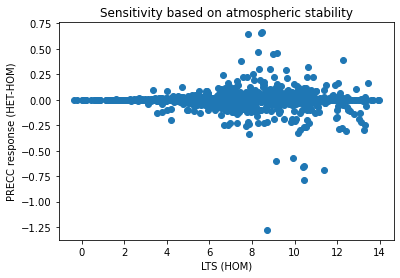

In [43]:
ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'

plt.scatter(np.squeeze(LTS.sel(case=ctrlCase).resample(time='1H').mean().dropna(dim='time')), 
            scamRain.sel(case=testCase)-scamRain.sel(case=ctrlCase) )

pct90 = np.nanpercentile(LTS.sel(case=ctrlCase).values, 90)
pct75 = np.nanpercentile(LTS.sel(case=ctrlCase).values, 75)
pct25 = np.nanpercentile(LTS.sel(case=ctrlCase).values, 25)
pct10 = np.nanpercentile(LTS.sel(case=ctrlCase).values, 10)

# plt.axvline(pct75,linestyle='--', color='k')
# plt.axvline(pct25,linestyle='--', color='k')

# plt.axvline(pct90,linestyle='--', color='grey')
# plt.axvline(pct10,linestyle='--', color='grey')

plt.xlabel('LTS (HOM)')
plt.ylabel('PRECC response (HET-HOM)')
plt.title('Sensitivity based on atmospheric stability')

Text(0.5, 1.0, 'Sensitivity based on atmospheric stability')

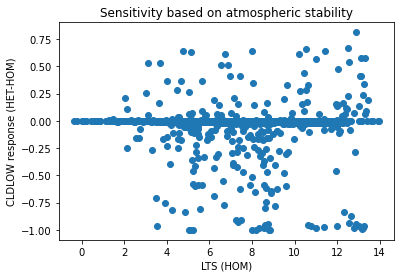

In [44]:
varSel = 'CLDLOW'

responseVar = np.squeeze(scamDS[varSel].resample(time='1H').mean().dropna(dim='time'))

plt.scatter(np.squeeze(LTS.sel(case=ctrlCase).resample(time='1H').mean().dropna(dim='time')), 
            responseVar.sel(case=testCase)-responseVar.sel(case=ctrlCase) )

plt.xlabel('LTS (HOM)')
plt.ylabel(varSel+' response (HET-HOM)')
plt.title('Sensitivity based on atmospheric stability')



In [45]:
## Get afternoon mean stability
selHours           = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=16))[0]
scamAfternoonMean  = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time').dropna(dim='time')


Text(0.5, 1.0, 'Sensitivity based on afternoon mean (12-4p LT) atmospheric stability')

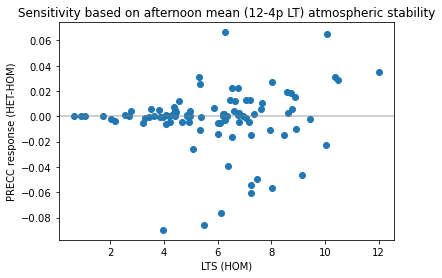

In [46]:

scamRainAfternoon  = scamAfternoonMean.PRECC*(3600*1e3) ## Convert units to mm/hr,

plt.scatter(np.squeeze(scamAfternoonMean.LTS.sel(case=ctrlCase)), 
            scamRainAfternoon.sel(case=testCase)-scamRainAfternoon.sel(case=ctrlCase) )

# pct90 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 90)
# pct75 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 75)
# pct25 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 25)
# pct10 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 10)

# plt.axvline(pct75,linestyle='--', color='k')
# plt.axvline(pct25,linestyle='--', color='k')

# plt.axvline(pct90,linestyle='--', color='grey')
# plt.axvline(pct10,linestyle='--', color='grey')

plt.axhline(0,linestyle='-',color='grey',alpha=0.5)

plt.xlabel('LTS (HOM)')
plt.ylabel('PRECC response (HET-HOM)')
plt.title('Sensitivity based on afternoon mean (12-4p LT) atmospheric stability')


Text(0.5, 1.0, 'Sensitivity based on afternoon mean (12-4p LT) atmospheric stability')

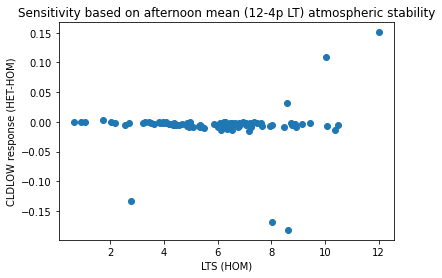

In [47]:
scamRainAfternoon  = scamAfternoonMean.CLDLOW ## Convert units to mm/hr,

plt.scatter(np.squeeze(scamAfternoonMean.LTS.sel(case=ctrlCase)), 
            scamRainAfternoon.sel(case=testCase)-scamRainAfternoon.sel(case=ctrlCase) )

# pct90 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 90)
# pct75 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 75)
# pct25 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 25)
# pct10 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 10)

# plt.axvline(pct75,linestyle='--', color='k')
# plt.axvline(pct25,linestyle='--', color='k')

# plt.axvline(pct90,linestyle='--', color='grey')
# plt.axvline(pct10,linestyle='--', color='grey')

plt.xlabel('LTS (HOM)')
plt.ylabel('CLDLOW response (HET-HOM)')
plt.title('Sensitivity based on afternoon mean (12-4p LT) atmospheric stability')


Text(0.5, 1.0, 'Sensitivity based on afternoon mean (12-4p LT) atmospheric stability')

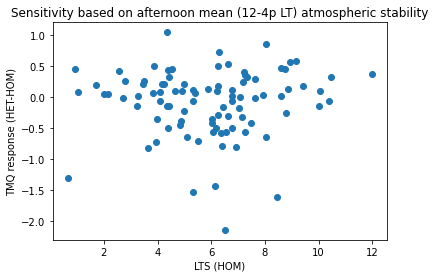

In [48]:
scamRainAfternoon  = scamAfternoonMean.TMQ 

plt.scatter(np.squeeze(scamAfternoonMean.LTS.sel(case=ctrlCase)), 
            scamRainAfternoon.sel(case=testCase)-scamRainAfternoon.sel(case=ctrlCase) )

# pct90 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 90)
# pct75 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 75)
# pct25 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 25)
# pct10 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 10)

# plt.axvline(pct75,linestyle='--', color='k')
# plt.axvline(pct25,linestyle='--', color='k')

# plt.axvline(pct90,linestyle='--', color='grey')
# plt.axvline(pct10,linestyle='--', color='grey')

plt.xlabel('LTS (HOM)')
plt.ylabel('TMQ response (HET-HOM)')
plt.title('Sensitivity based on afternoon mean (12-4p LT) atmospheric stability')


In [49]:
scamRainAfternoon  = scamAfternoonMean.PRECC*(3600*1e3) ## Convert units to mm/hr,
midLev = np.where( (scamDS_daytime.levInterp.values<=550.0) & (scamDS_daytime.levInterp.values>=450.0) )[0]

plt.scatter(np.squeeze(scamAfternoonMean.OMEGA_interp.isel(levInterp=midLev).mean(dim='levInterp').sel(case=ctrlCase)), 
            scamRainAfternoon.sel(case=testCase)-scamRainAfternoon.sel(case=ctrlCase) )

# pct90 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 90)
# pct75 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 75)
# pct25 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 25)
# pct10 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 10)

# plt.axvline(pct75,linestyle='--', color='k')
# plt.axvline(pct25,linestyle='--', color='k')

# plt.axvline(pct90,linestyle='--', color='grey')
# plt.axvline(pct10,linestyle='--', color='grey')

plt.xlabel('OMEGA [550-450hPa] (HOM)')
plt.ylabel('PRECC response (HET-HOM)')
plt.title('Sensitivity based on afternoon mean (12-4p LT) OMEGA_500')


NameError: name 'scamDS_daytime' is not defined

In [50]:
## Get afternoon mean stability
selHours           = np.where((scamDS['time.hour'].values>=9) & (scamDS['time.hour'].values<=12))[0]
scamAfternoonMean  = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time').dropna(dim='time')


Text(0.5, 1.0, 'Sensitivity based on morning mean (9a-12p LT) atmospheric stability')

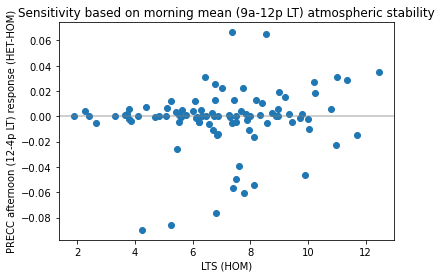

In [51]:
selHours           = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=16))[0]
scamRainAfternoon  = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time').dropna(dim='time').PRECC*(3600*1e3) ## Convert units to mm/hr,

plt.scatter(np.squeeze(scamAfternoonMean.LTS.sel(case=ctrlCase)), 
            scamRainAfternoon.sel(case=testCase)-scamRainAfternoon.sel(case=ctrlCase) )

# pct90 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 90)
# pct75 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 75)
# pct25 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 25)
# pct10 = np.nanpercentile(scamAfternoonMean.LTS.sel(case='clubbMF').values, 10)

# plt.axvline(pct75,linestyle='--', color='k')
# plt.axvline(pct25,linestyle='--', color='k')

# plt.axvline(pct90,linestyle='--', color='grey')
# plt.axvline(pct10,linestyle='--', color='grey')

plt.axhline(0,linestyle='-',color='grey',alpha=0.5)

plt.xlabel('LTS (HOM)')
plt.ylabel('PRECC afternoon (12-4p LT) response (HET-HOM)')
plt.title('Sensitivity based on morning mean (9a-12p LT) atmospheric stability')


## Experimenting...

Try Meng's definition of days

In [52]:
q_var = 'CLDLIQ_interp'
q_ctl = scamDS.sel(case='clubbMF_L0eq250')[q_var]

p_var = 'PRECT'
p_ctl = scamDS.sel(case='clubbMF_L0eq250')[p_var]

plim = 0.5   #mm/day
qlim = 1e-6  #kg/kg

minHr = 6
maxHr = 18
selHours = np.where( (scamDS['time.hour'].values>=minHr) & (scamDS['time.hour'].values<=maxHr) )[0]

levSel     = np.where((scamDS.levInterp.values>600))[0]

# Daily mean rain rate in right units:
p_dailyMean = p_ctl.isel(time=selHours).resample(time='1D').mean(dim='time')*1e3*86400

# Select lower levels
q_dailyMax = q_ctl.isel(levInterp=levSel, time=selHours).resample(time='1D').mean(dim='time').max(dim='levInterp')


# Define days using their indices...
iRainDay  = np.where(  p_dailyMean >= plim)[0]
iCloudDay = np.where( (p_dailyMean < plim) & (q_dailyMax>=qlim) )[0]
iClearDay = np.where( (p_dailyMean < plim) & (q_dailyMax<qlim) )[0]

print('Number of rainy  days: ', len(iRainDay))
print('Number of cloudy days: ', len(iCloudDay))
print('Number of clear  days: ', len(iClearDay))


Number of rainy  days:  51
Number of cloudy days:  10
Number of clear  days:  31


In [53]:
# Also get those days in the full DS 

iclear_times  = []
icloudy_times = []
irainy_times  = []
for iT in range(len(p_dailyMean.time.values)):
    thisDay = p_dailyMean.isel(time=iT)
    iTimes = np.where((scamDS['time.year'].values==thisDay['time.year'].values) & 
                      (scamDS['time.month'].values==thisDay['time.month'].values) &
                      (scamDS['time.day'].values==thisDay['time.day'].values))[0]
    
    if iT in iClearDay:
        iclear_times = np.append(iclear_times, iTimes) 
    elif iT in iCloudDay:
        icloudy_times = np.append(icloudy_times, iTimes) 
    elif iT in iRainDay: 
        irainy_times = np.append(irainy_times, iTimes) 
    else:
        print('Day not defined!! iT = ',iT)
        
clearDays_DS  = scamDS.isel(time=iclear_times.astype(int))
cloudyDays_DS = scamDS.isel(time=icloudy_times.astype(int))
rainyDays_DS  = scamDS.isel(time=irainy_times.astype(int))


In [54]:
clearDays_hourlyMean  = clearDays_DS.groupby('time.hour').mean(dim='time')
cloudyDays_hourlyMean = cloudyDays_DS.groupby('time.hour').mean(dim='time')
rainyDays_hourlyMean  = rainyDays_DS.groupby('time.hour').mean(dim='time')



In [55]:
clearDays_DSh2  = scamDS_h2.isel(time=iclear_times.astype(int))
cloudyDays_DSh2 = scamDS_h2.isel(time=icloudy_times.astype(int))
rainyDays_DSh2  = scamDS_h2.isel(time=irainy_times.astype(int))

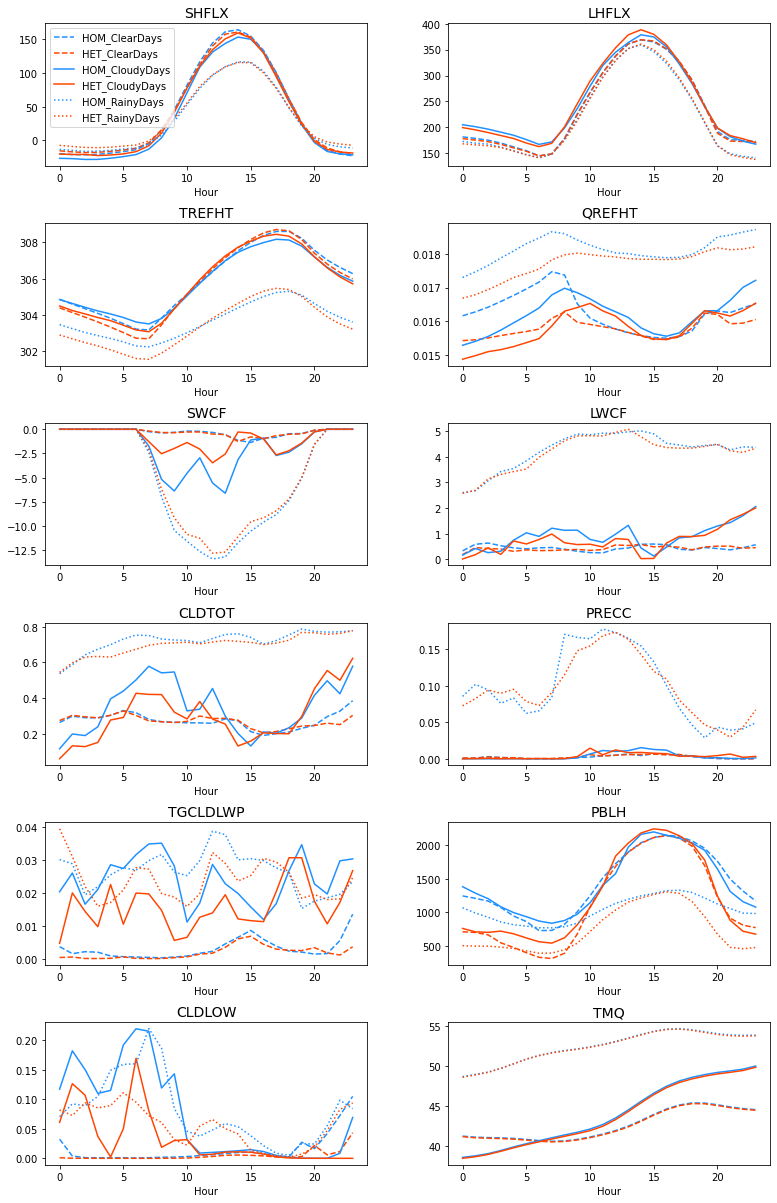

In [56]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECC',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    if pltVars[iPlt]=='PRECC': 
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 '--',color='dodgerblue', label='HOM_ClearDays')
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 '--',color='orangered', label='HET_ClearDays')   
        
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 color='dodgerblue', label='HOM_CloudyDays')
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 color='orangered', label='HET_CloudyDays')   
        
        axs[iPlt].plot(rainyDays_hourlyMean.hour.values, np.squeeze(rainyDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 ':',color='dodgerblue', label='HOM_RainyDays')
        axs[iPlt].plot(rainyDays_hourlyMean.hour.values, np.squeeze(rainyDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 ':',color='orangered', label='HET_RainyDays')   

        
    else: 
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             '--',color='dodgerblue', label='HOM_ClearDays')
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             '--',color='orangered', label='HET_ClearDays')
        
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label='HOM_CloudyDays')
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label='HET_CloudyDays')
        
        axs[iPlt].plot(rainyDays_hourlyMean.hour.values, np.squeeze(rainyDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             ':',color='dodgerblue', label='HOM_RainyDays')
        axs[iPlt].plot(rainyDays_hourlyMean.hour.values, np.squeeze(rainyDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             ':',color='orangered', label='HET_RainyDays')


    if iPlt==0:
        axs[iPlt].legend(fontsize=10,)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


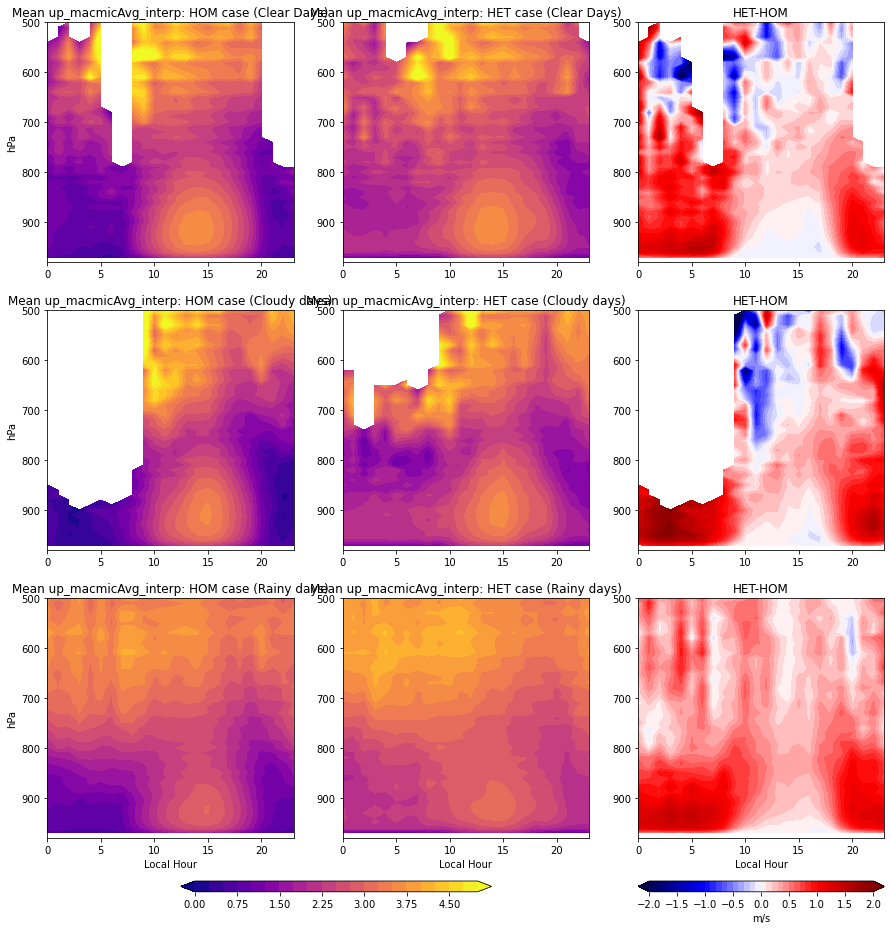

In [58]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'up_macmicAvg_interp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0,5.25,0.25), np.arange(-2,2.1,0.1),   #L0=250
                               # np.arange(0,2.7,0.1), np.arange(-2,2.1,0.1),    #L0=50
                               weight=True)



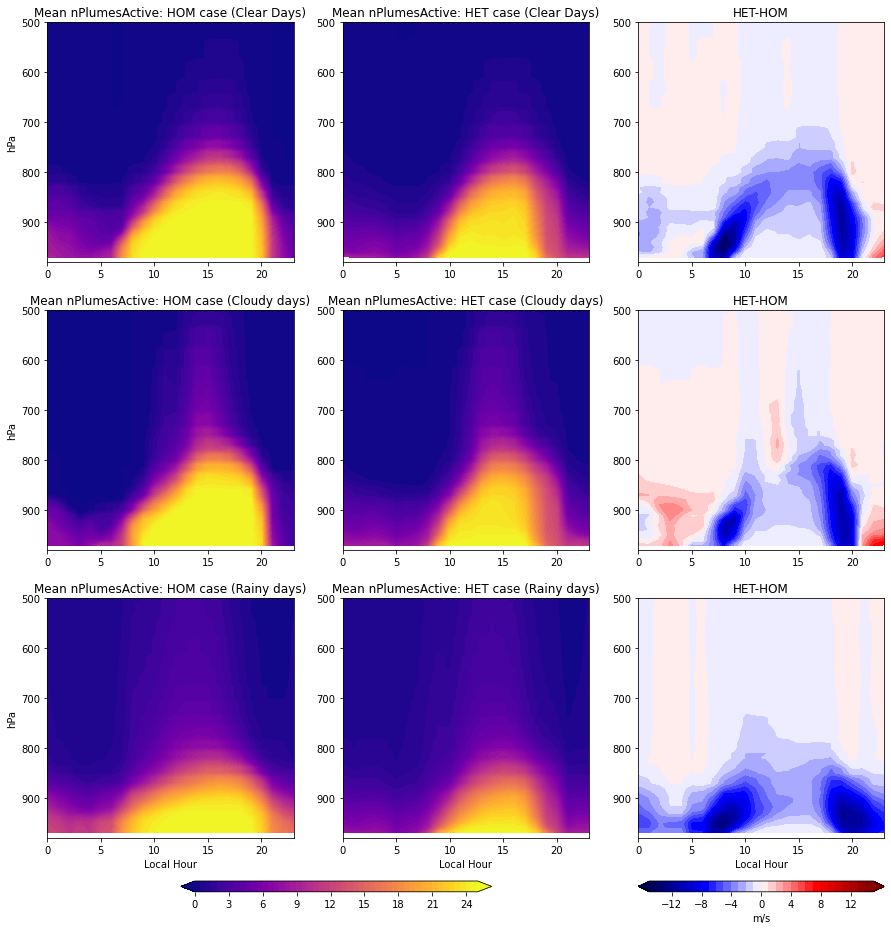

In [59]:
plotTimeHeight_h2_caseMean(clearDays_DS, cloudyDays_DS, rainyDays_DS,
                            'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'nPlumesActive', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0,25.5,0.5), np.arange(-15,16,1),
                               weight=False)


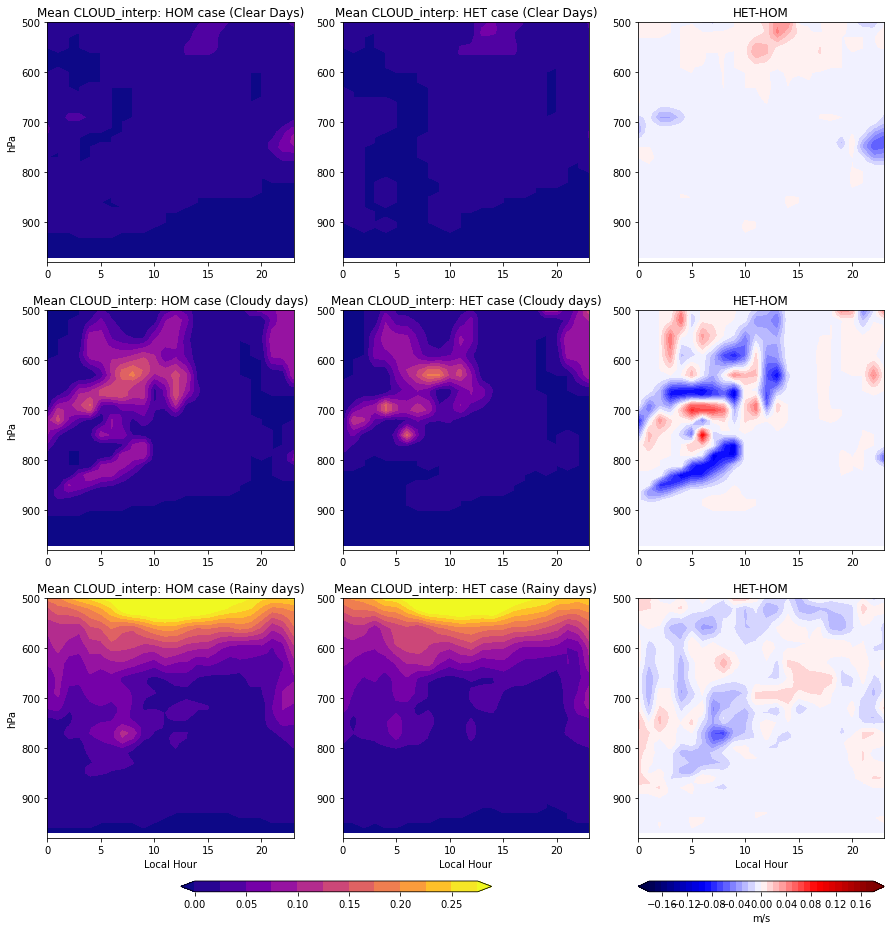

In [60]:
plotTimeHeight_h2_caseMean(clearDays_DS, cloudyDays_DS, rainyDays_DS,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'CLOUD_interp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0,0.3,0.025), np.arange(-0.18,0.19,0.01),
                               weight=False)



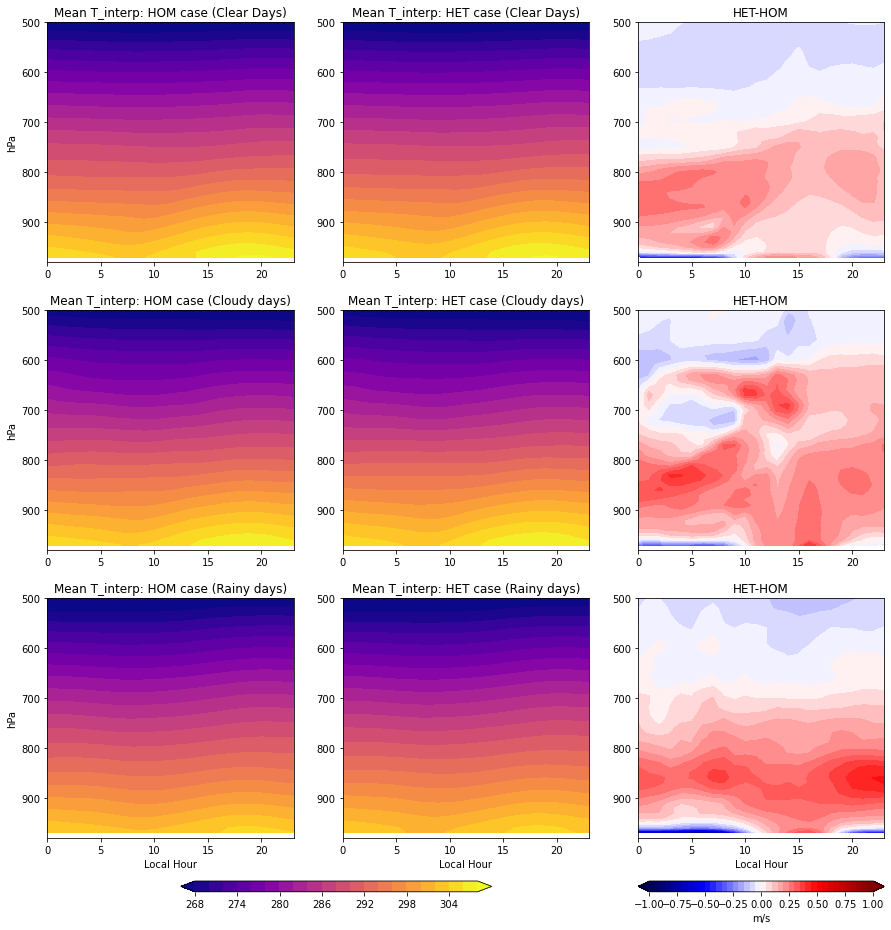

In [61]:
plotTimeHeight_h2_caseMean(clearDays_DS, cloudyDays_DS, rainyDays_DS,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'T_interp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               # np.arange(268, 310, 2), np.arange(-2,2.1,0.1),
                               np.arange(268, 310, 2), np.arange(-1,1.05,0.05),
                               weight=False)


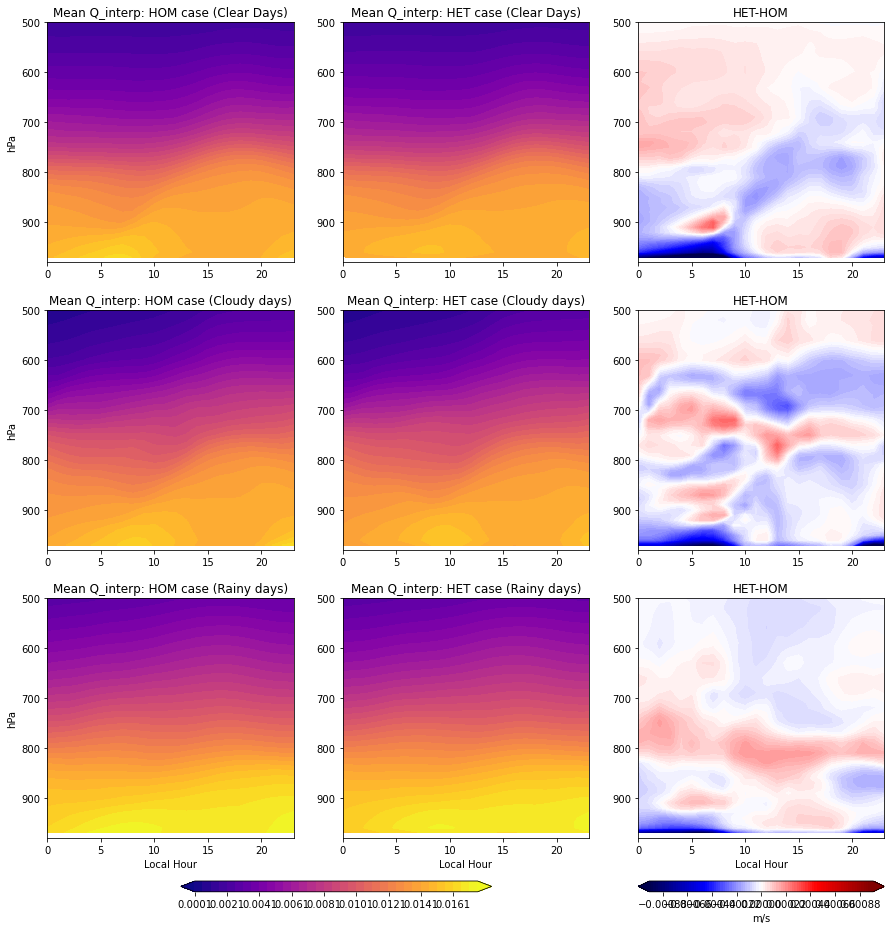

In [62]:
plotTimeHeight_h2_caseMean(clearDays_DS, cloudyDays_DS, rainyDays_DS,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'Q_interp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0.1e-3, 1.8e-2, 0.5e-3), np.arange(-1e-3,1.02e-3,0.02e-3),
                               weight=False)


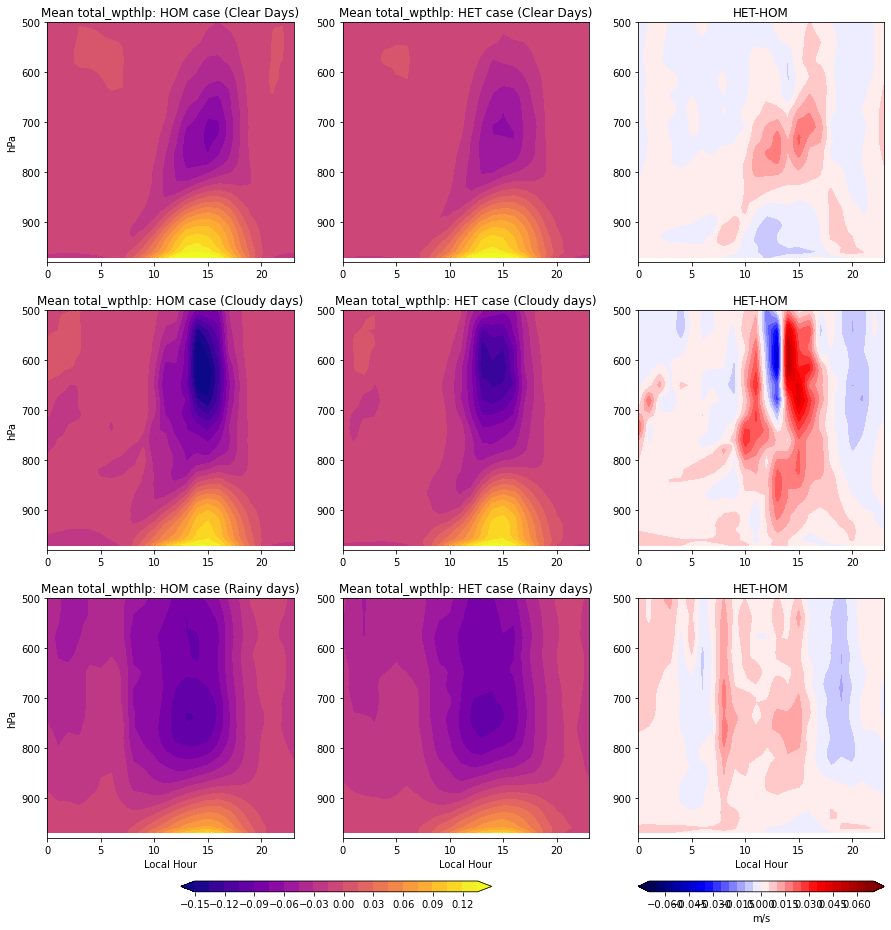

In [63]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_wpthlp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(-0.15,0.15,0.015), np.arange(-0.07,0.0705,0.005),
                               # np.arange(-0.1,0.15,0.015), np.arange(-0.03,0.0301,0.001),
                               weight=False)

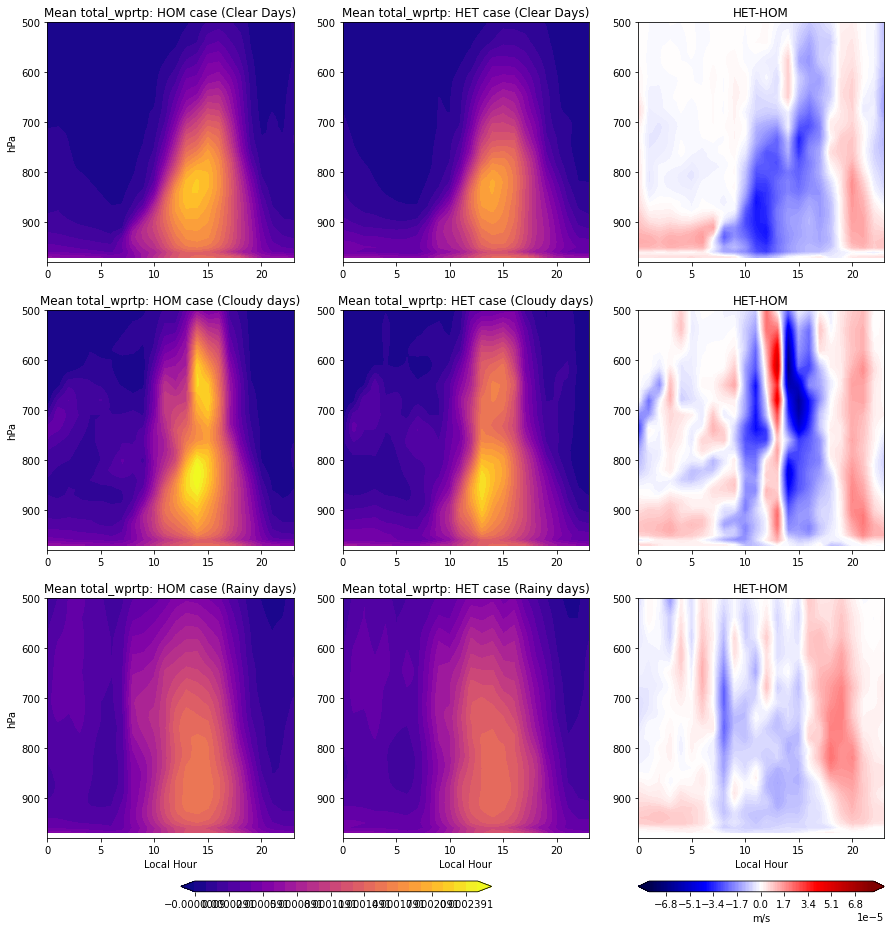

In [64]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_wprtp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(-9e-7,2.5e-4,1e-5), np.arange(-8.0e-5,8.1e-5,0.1e-5),
                               # np.arange(-9e-7,2.2e-4,1e-5), np.arange(-6.0e-5,6.1e-5,0.1e-5),
                               weight=False)

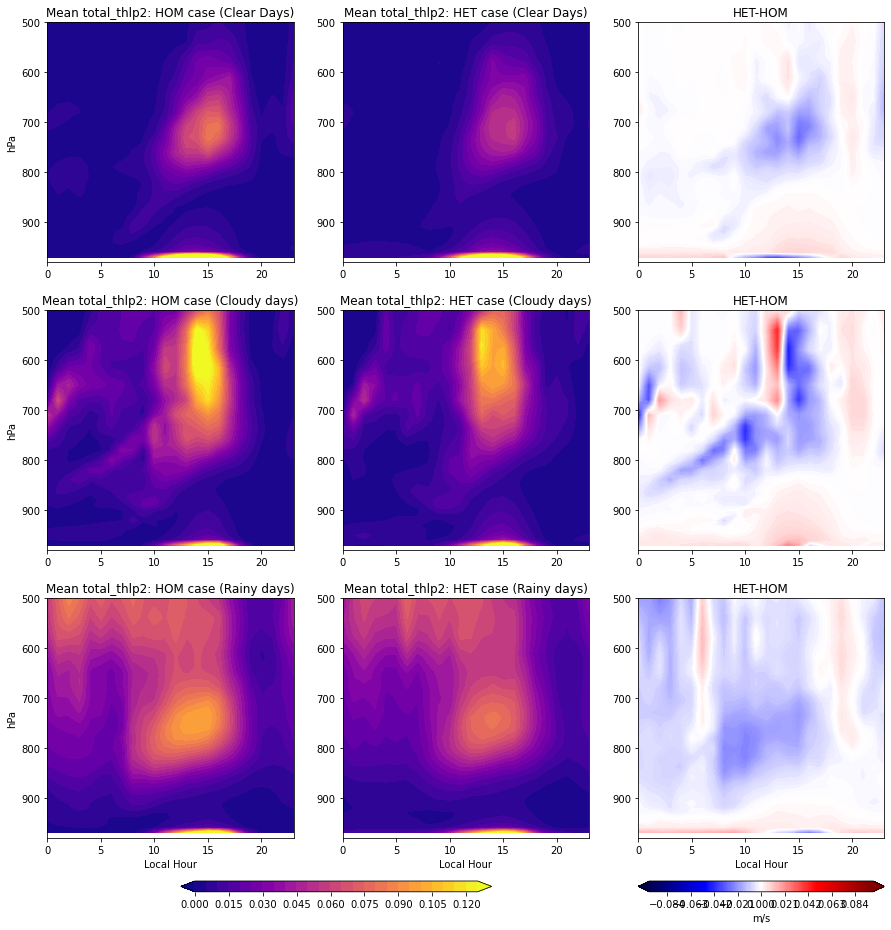

In [65]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_thlp2', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0,0.13,0.005), np.arange(-0.1,0.101,0.001),
                               weight=False)

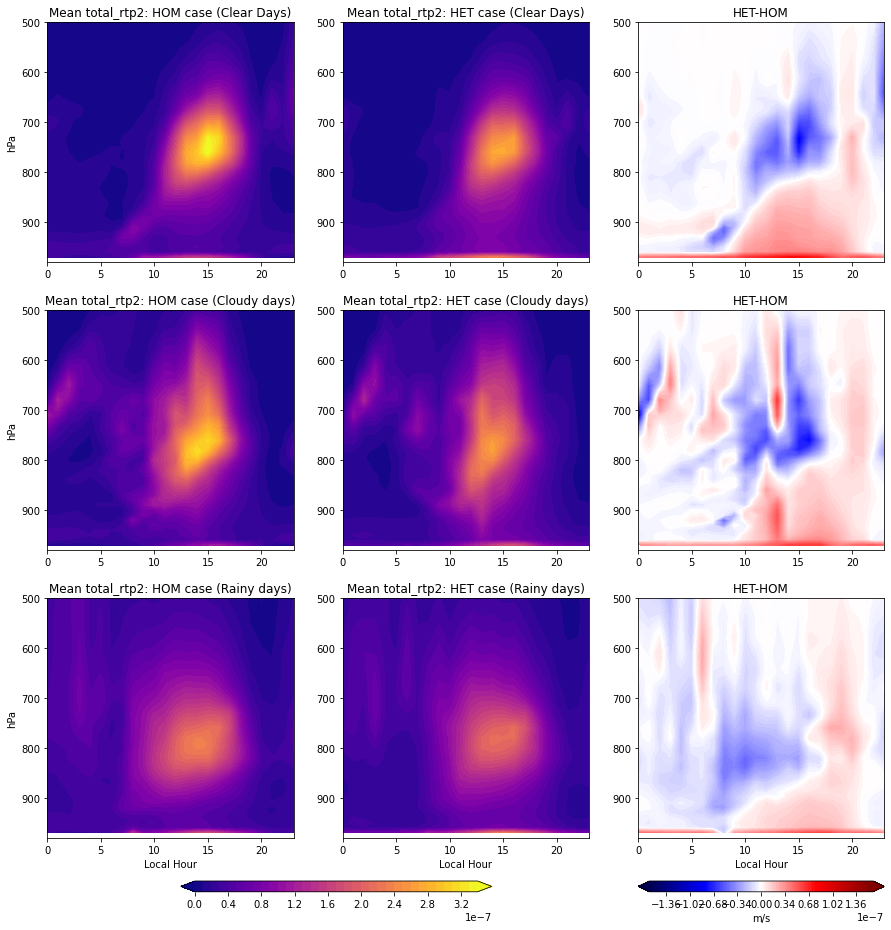

In [66]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_rtp2', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0,3.5e-7,1e-8), np.arange(-1.6e-7,1.62e-7,0.02e-7),
                               weight=False)

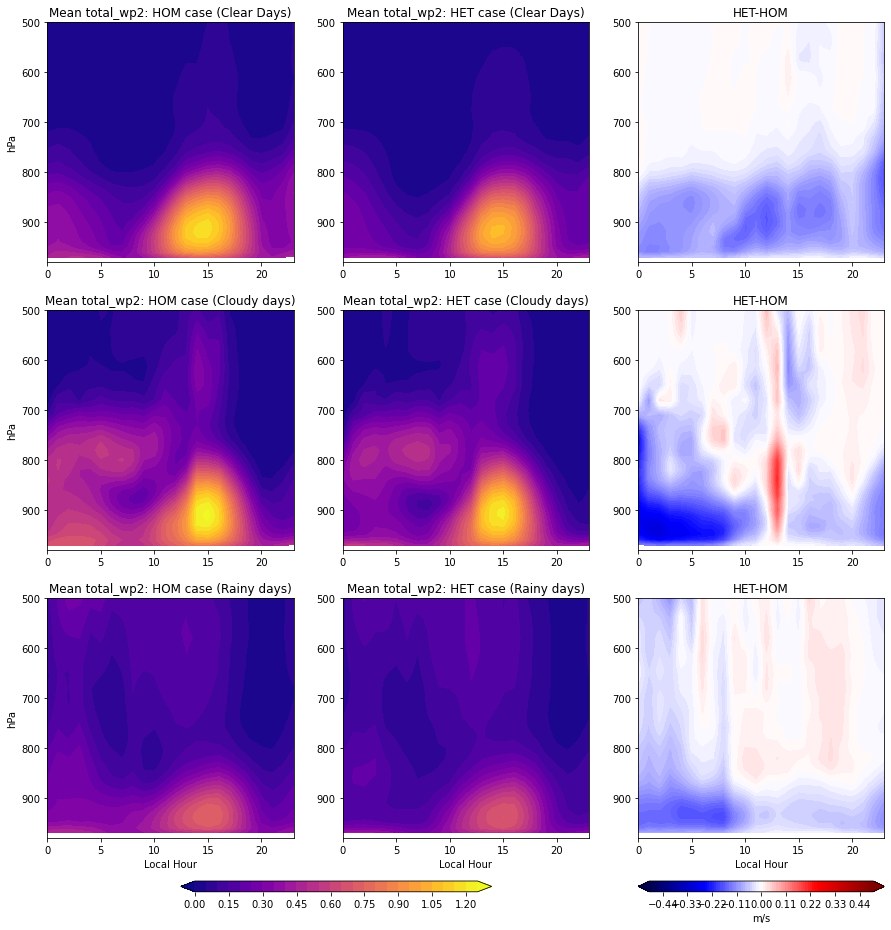

In [68]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_wp2', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(0,1.3,0.05), np.arange(-0.5,0.51,0.01),
                               weight=False)

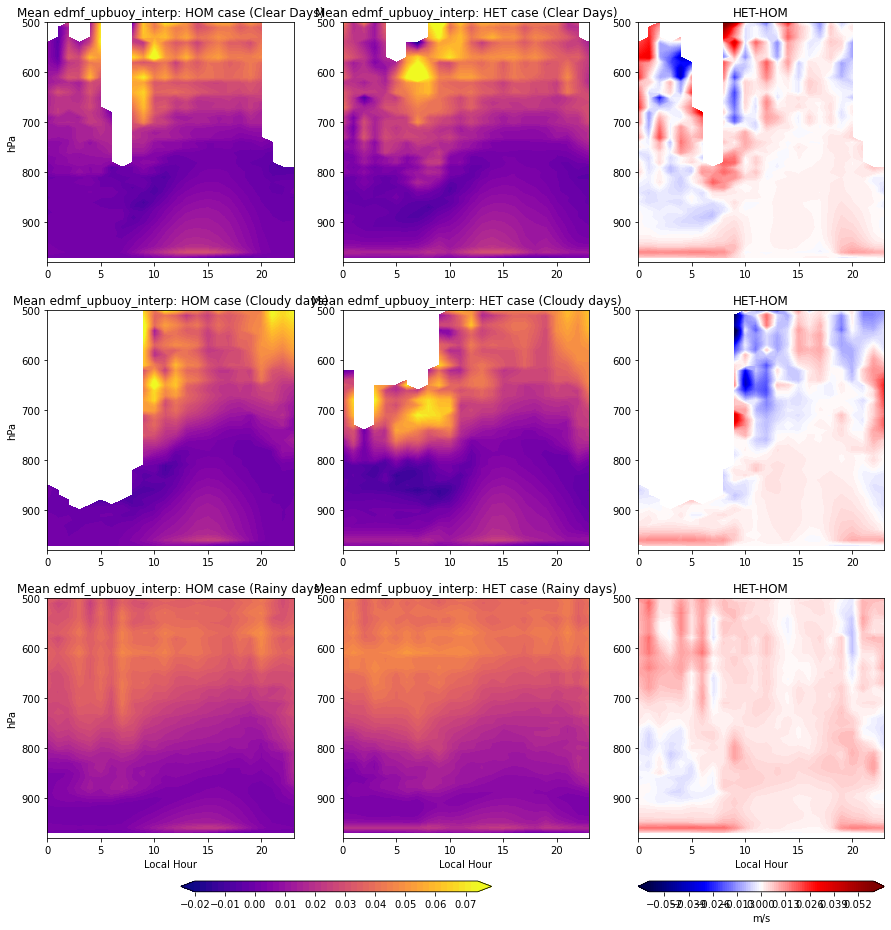

In [69]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, cloudyDays_DSh2, rainyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'edmf_upbuoy_interp', 
                           [' (Clear Days)', ' (Cloudy days)', ' (Rainy days)'], 
                               np.arange(-0.02,0.076,0.002), np.arange(-0.06, 0.061, 0.001),
                               # np.arange(-0.01,0.03,0.002), np.arange(-0.02, 0.021, 0.001),
                               weight=True)


**Try using the lapse rate between sfc and some height?**

In [89]:
## Get lapse rate between surface and some level 
##   Note: normally, the height at whatever level would be Z3 - PHIS, but PHIS = 0 everywhere here. 

topLev = 750.0  # hPa
scamTopLev = scamDS.sel(levInterp=topLev)

botLev = 950.0 
scamBotLev = scamDS.sel(levInterp=botLev)

dT = scamTopLev.T_interp - scamDS.TREFHT.values
# dT = scamTopLev.T_interp - scamBotLev.T_interp
dZ = (scamTopLev.Z3_interp - 2.0) * 1e-3
# dZ = (scamTopLev.Z3_interp - scamBotLev.Z3_interp) * 1e-3

scamDS['LapseRate'] = -dT/dZ 

print(scamDS['LapseRate'].isel(time=150))

# print('T @ 700 hPa: ', scam700.T_interp.isel(time=150).values)
# print('T2M: ', scamDS.sel(levInterp=700.0).sel(case='clubbMF_L0eq50').isel(time=150).TREFHT.values)
# print('Height @700 hPa: ', scam700.Z3_interp.isel(time=150).values)

# dT = scam700.T_interp.isel(time=150).values - scamDS.sel(case='clubbMF_L0eq50').isel(time=150).TREFHT.values
# dZ = (scam700.Z3_interp.isel(time=150).values - 2.0) * 1e-3
# print(dT/dZ)


<xarray.DataArray 'LapseRate' (case: 2)>
array([7.75653023, 8.19745946])
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
    time     datetime64[ns] 2015-06-02T12:33:30
  * case     (case) object 'clubbMF_L0eq250' 'claspMF_L0eq250_rand'


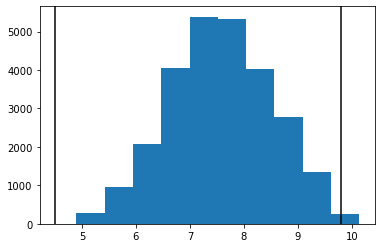

In [90]:
plt.hist(scamDS['LapseRate'].sel(case='clubbMF_L0eq250').values)
plt.axvline(4.5,color='k')
plt.axvline(9.8,color='k')

In [91]:
# What period do we want to base things on? Let's start with daytime to make life easy... 6a to 6p
selHours = np.where( (scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=18) )[0]
scamDS_daytime = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time')



25th percentile of daily mean  LapseRate :  7.586567488515179
75th percentile of daily mean  LapseRate :  8.706748822540154


Text(0.5, 1.0, 'Afternoon mean (12p-6p) LapseRate (up to 750 hPa)')

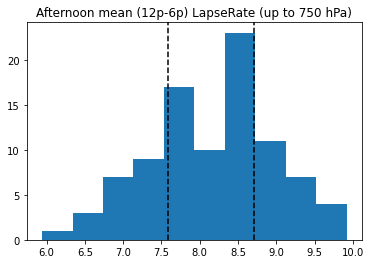

In [92]:
varDef = 'LapseRate'
pct25 = np.nanpercentile(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 25)
pct75 = np.nanpercentile(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 75)

# print('Shape of daily mean array: ', np.shape(scamDS_daytime['cldForc'].values)) 
print('25th percentile of daily mean ', varDef, ': ', pct25)
print('75th percentile of daily mean ', varDef, ': ', pct75)

plt.hist(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values)
# plt.axvline(4.5,color='k')
# plt.axvline(9.8,color='k')
plt.axvline(pct25,color='k',linestyle='--')
plt.axvline(pct75,color='k',linestyle='--')
plt.title('Afternoon mean (12p-6p) '+varDef+' (up to 750 hPa)')


In [93]:
clearDays_mean  = scamDS_daytime.isel(time=np.where(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values <= pct25)[0])
cloudyDays_mean = scamDS_daytime.isel(time=np.where(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values >= pct75)[0])


In [94]:
# Also get those days in the full DS 

iclear_times  = []
icloudy_times = []
iother_times  = []

for iT in range(len(scamDS_daytime.time.values)):
    thisDay_var = scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').isel(time=iT)
    
    iTimes = np.where((scamDS['time.year'].values==thisDay_var['time.year'].values) & 
                      (scamDS['time.month'].values==thisDay_var['time.month'].values) &
                      (scamDS['time.day'].values==thisDay_var['time.day'].values))[0]
    
    if thisDay_var.values <= pct25:
        iclear_times = np.append(iclear_times, iTimes) 
    elif thisDay_var.values >= pct75:
        icloudy_times = np.append(icloudy_times, iTimes) 
    else: 
        iother_times = np.append(iother_times, iTimes) 
        
lessStableDays_DS = scamDS.isel(time=iclear_times.astype(int))
moreStableDays_DS = scamDS.isel(time=icloudy_times.astype(int))
middleDays_DS     = scamDS.isel(time=iother_times.astype(int))


In [95]:
lessStableDays_DSh2 = scamDS_h2.isel(time=iclear_times.astype(int))
moreStableDays_DSh2 = scamDS_h2.isel(time=icloudy_times.astype(int))
middleDays_DSh2     = scamDS_h2.isel(time=iother_times.astype(int))


In [96]:
lessStableDays_hourlyMean = lessStableDays_DS.groupby('time.hour').mean(dim='time')
moreStableDays_hourlyMean = moreStableDays_DS.groupby('time.hour').mean(dim='time')
middleDays_hourlyMean     = middleDays_DS.groupby('time.hour').mean(dim='time')



In [97]:
middleDays_hourlyMean.case.values

array(['clubbMF_L0eq250', 'claspMF_L0eq250_rand'], dtype=object)

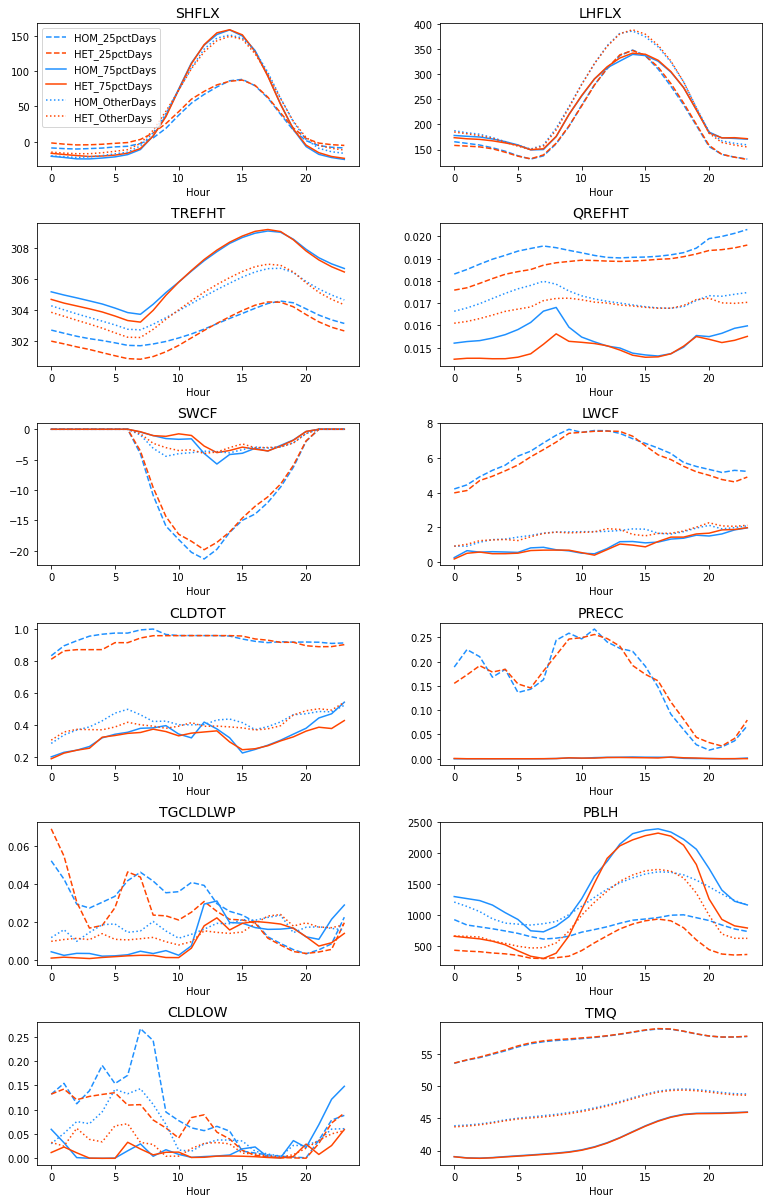

In [98]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECC',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    if pltVars[iPlt]=='PRECC': 
        axs[iPlt].plot(lessStableDays_hourlyMean.hour.values, np.squeeze(lessStableDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 '--',color='dodgerblue', label='HOM_25pctDays')
        axs[iPlt].plot(lessStableDays_hourlyMean.hour.values, np.squeeze(lessStableDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 '--',color='orangered', label='HET_25pctDays')   
        
        axs[iPlt].plot(moreStableDays_hourlyMean.hour.values, np.squeeze(moreStableDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 color='dodgerblue', label='HOM_75pctDays')
        axs[iPlt].plot(moreStableDays_hourlyMean.hour.values, np.squeeze(moreStableDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 color='orangered', label='HET_75pctDays')   
        
    else: 
        axs[iPlt].plot(lessStableDays_hourlyMean.hour.values, np.squeeze(lessStableDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             '--',color='dodgerblue', label='HOM_25pctDays')
        axs[iPlt].plot(lessStableDays_hourlyMean.hour.values, np.squeeze(lessStableDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             '--',color='orangered', label='HET_25pctDays')
        
        axs[iPlt].plot(moreStableDays_hourlyMean.hour.values, np.squeeze(moreStableDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label='HOM_75pctDays')
        axs[iPlt].plot(moreStableDays_hourlyMean.hour.values, np.squeeze(moreStableDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label='HET_75pctDays')
        
        axs[iPlt].plot(middleDays_hourlyMean.hour.values, np.squeeze(middleDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             ':',color='dodgerblue', label='HOM_OtherDays')
        axs[iPlt].plot(middleDays_hourlyMean.hour.values, np.squeeze(middleDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             ':',color='orangered', label='HET_OtherDays')
                

    if iPlt==0:
        axs[iPlt].legend(fontsize=10,)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

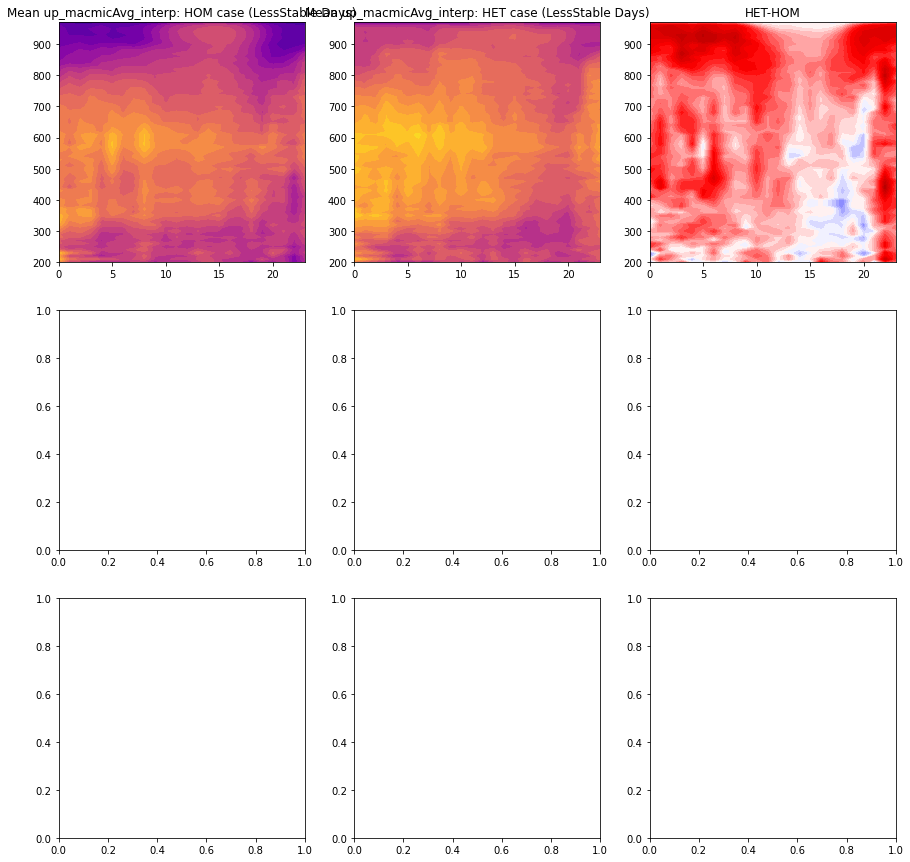

In [105]:
plotTimeHeight_h2_caseMean(lessStableDays_DSh2, middleDays_DSh2, moreStableDays_DSh2, 
                            'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'up_macmicAvg_interp', 
                           [' (LessStable Days)', ' (middle days)', ' (MoreStable days)'], 
                               np.arange(0,5.25,0.25), np.arange(-2,2.1,0.1),
                               # np.arange(0,2.3,0.1), np.arange(-2,2.1,0.1),
                               weight=True)

TypeError: getStatSigCI() takes 5 positional arguments but 6 were given

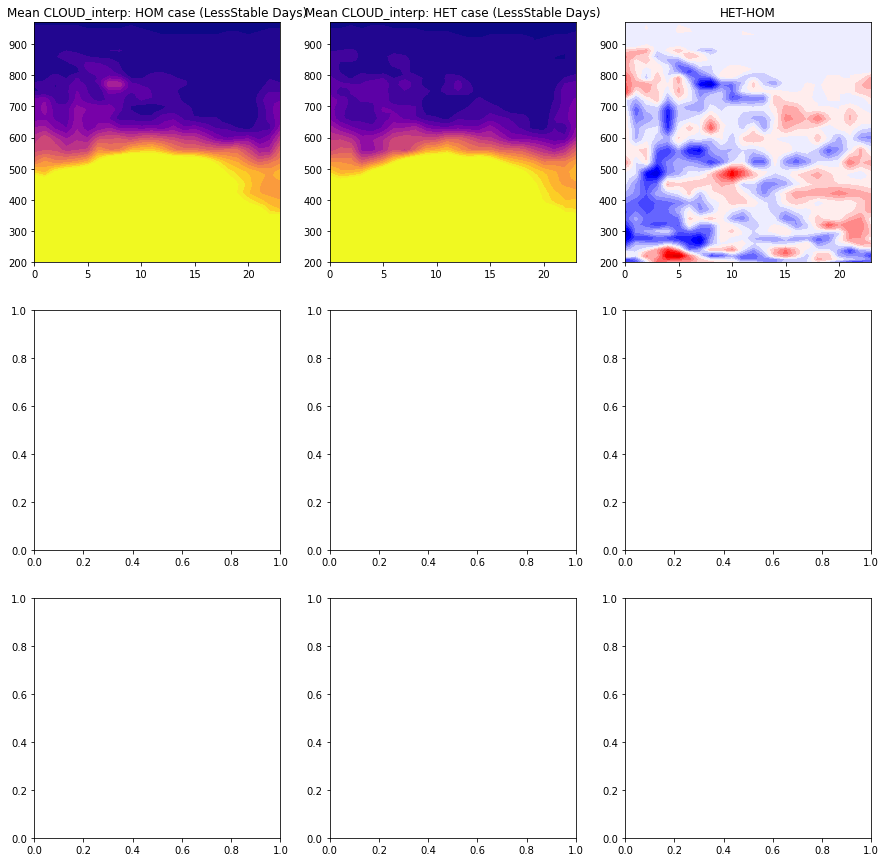

In [106]:
plotTimeHeight_h2_caseMean(lessStableDays_DS, middleDays_DS, moreStableDays_DS, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'CLOUD_interp', 
                           [' (LessStable Days)', ' (middle days)', ' (MoreStable days)'], 
                               np.arange(0,0.4,0.025), np.arange(-0.15,0.16,0.01),
                               weight=False)


**Try just taking some percentiles?**

In [70]:
## What if we just base clear/cloudy days on net cloud radiative forcing (SW+LW)? 
scamDS['cldForc'] = scamDS.SWCF+scamDS.LWCF


In [71]:
# What period do we want to base things on? Let's start with daytime to make life easy... 6a to 6p
selHours = np.where( (scamDS['time.hour'].values>=6) & (scamDS['time.hour'].values<=18) )[0]
scamDS_daytime = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time')

scamDS_daytimeSum = scamDS.isel(time=selHours).resample(time='1D').sum(dim='time')


# Variable to define days based on 
# varDef = 'TGCLDLWP'
varDef = 'LTS'

pct25 = np.nanpercentile(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 25)
pct75 = np.nanpercentile(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 75)

# print('Shape of daily mean array: ', np.shape(scamDS_daytime['cldForc'].values)) 
print('25th percentile of daily mean ', varDef, ': ', pct25)
print('75th percentile of daily mean ', varDef, ': ', pct75)



25th percentile of daily mean  LTS :  5.319085227019915
75th percentile of daily mean  LTS :  7.896604799024131


Text(0.5, 1.0, 'Daily mean (6a-6p) LTS')

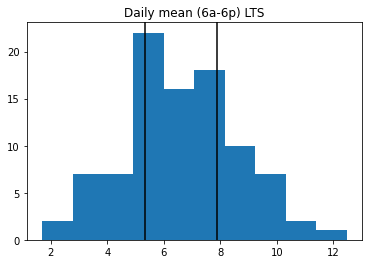

In [72]:
plt.hist(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values)
plt.axvline(pct25,color='k')
plt.axvline(pct75,color='k')
plt.title('Daily mean (6a-6p) '+varDef)

In [73]:
clearDays_mean  = scamDS_daytime.isel(time=np.where(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values <= pct25)[0])
cloudyDays_mean = scamDS_daytime.isel(time=np.where(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values >= pct75)[0])


In [74]:
# Also get those days in the full DS 

iclear_times  = []
icloudy_times = []
iother_times  = []
for iT in range(len(scamDS_daytime.time.values)):
    thisDay_var = scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').isel(time=iT)
    
    iTimes = np.where((scamDS['time.year'].values==thisDay_var['time.year'].values) & 
                      (scamDS['time.month'].values==thisDay_var['time.month'].values) &
                      (scamDS['time.day'].values==thisDay_var['time.day'].values))[0]
    
    if thisDay_var.values <= pct25:
        iclear_times = np.append(iclear_times, iTimes) 
    elif thisDay_var.values >= pct75:
        icloudy_times = np.append(icloudy_times, iTimes) 
    else: 
        iother_times = np.append(iother_times, iTimes) 
        
clearDays_DS  = scamDS.isel(time=iclear_times.astype(int))
cloudyDays_DS = scamDS.isel(time=icloudy_times.astype(int))
otherDays_DS  = scamDS.isel(time=iother_times.astype(int))


In [75]:
clearDays_hourlyMean  = clearDays_DS.groupby('time.hour').mean(dim='time')
cloudyDays_hourlyMean = cloudyDays_DS.groupby('time.hour').mean(dim='time')
otherDays_hourlyMean  = otherDays_DS.groupby('time.hour').mean(dim='time')



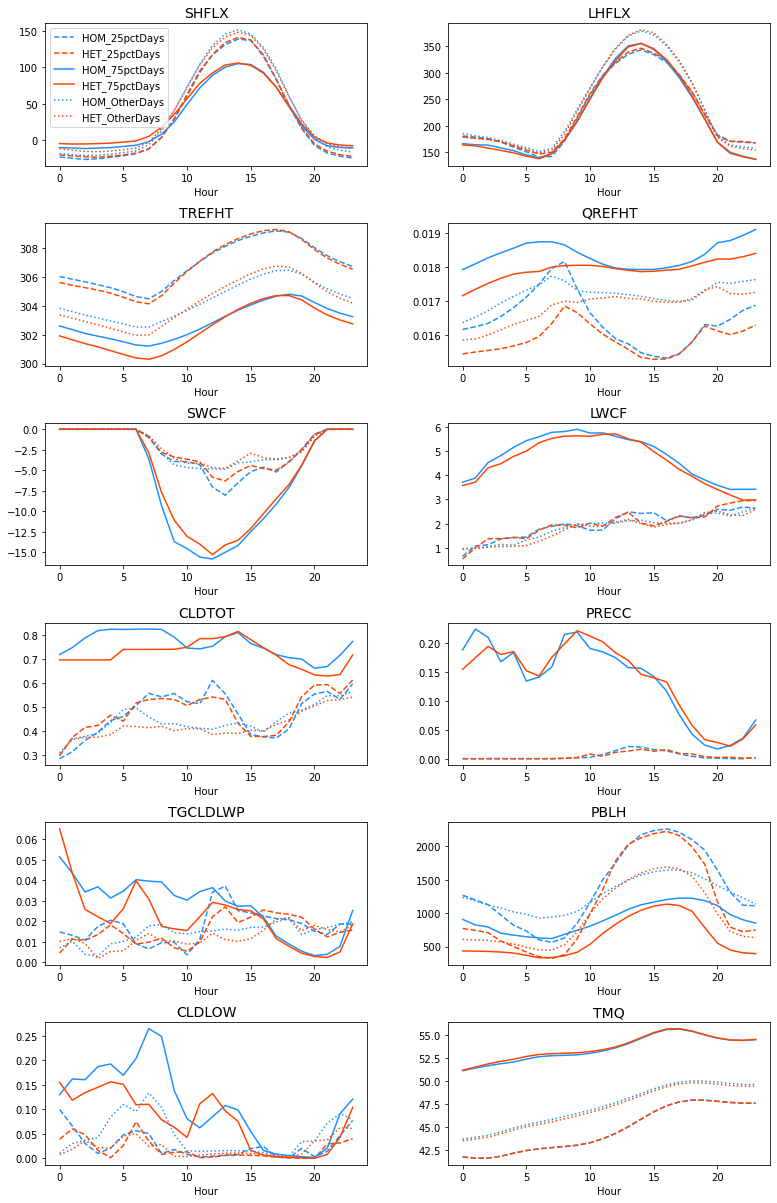

In [76]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECC',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250_rand'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    if pltVars[iPlt]=='PRECC': 
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 '--',color='dodgerblue', label='HOM_25pctDays')
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 '--',color='orangered', label='HET_25pctDays')   
        
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 color='dodgerblue', label='HOM_75pctDays')
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 color='orangered', label='HET_75pctDays')   
        
    else: 
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             '--',color='dodgerblue', label='HOM_25pctDays')
        axs[iPlt].plot(clearDays_hourlyMean.hour.values, np.squeeze(clearDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             '--',color='orangered', label='HET_25pctDays')
        
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label='HOM_75pctDays')
        axs[iPlt].plot(cloudyDays_hourlyMean.hour.values, np.squeeze(cloudyDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label='HET_75pctDays')
        
        axs[iPlt].plot(otherDays_hourlyMean.hour.values, np.squeeze(otherDays_hourlyMean[pltVars[iPlt]].sel(case=ctrlCase).values), 
             ':',color='dodgerblue', label='HOM_OtherDays')
        axs[iPlt].plot(otherDays_hourlyMean.hour.values, np.squeeze(otherDays_hourlyMean[pltVars[iPlt]].sel(case=testCase).values), 
             ':',color='orangered', label='HET_OtherDays')
                

    if iPlt==0:
        axs[iPlt].legend(fontsize=10,)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


In [77]:
clearDays_DSh2  = scamDS_h2.isel(time=iclear_times.astype(int))
cloudyDays_DSh2 = scamDS_h2.isel(time=icloudy_times.astype(int))
otherDays_DSh2  = scamDS_h2.isel(time=iother_times.astype(int))

**Make a bunch of cool time-height plots about it!**

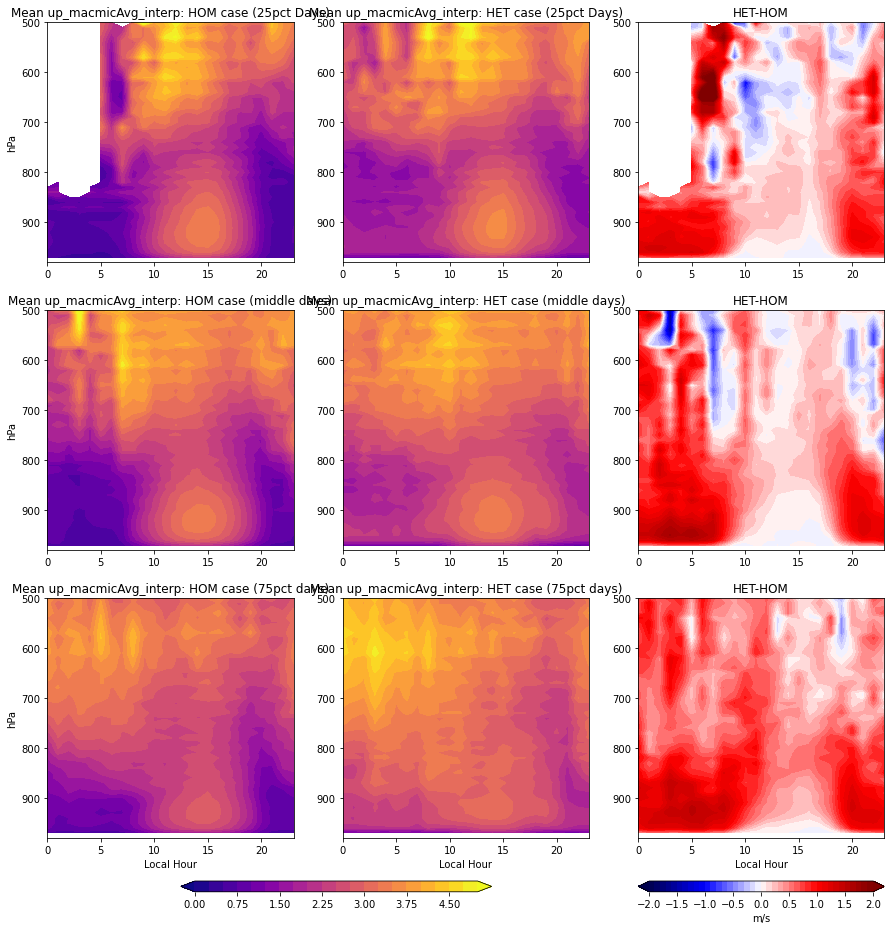

In [78]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2, 
                            'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'up_macmicAvg_interp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0,5.25,0.25), np.arange(-2,2.1,0.1),
                               # np.arange(0,2.3,0.1), np.arange(-2,2.1,0.1),
                               weight=True)

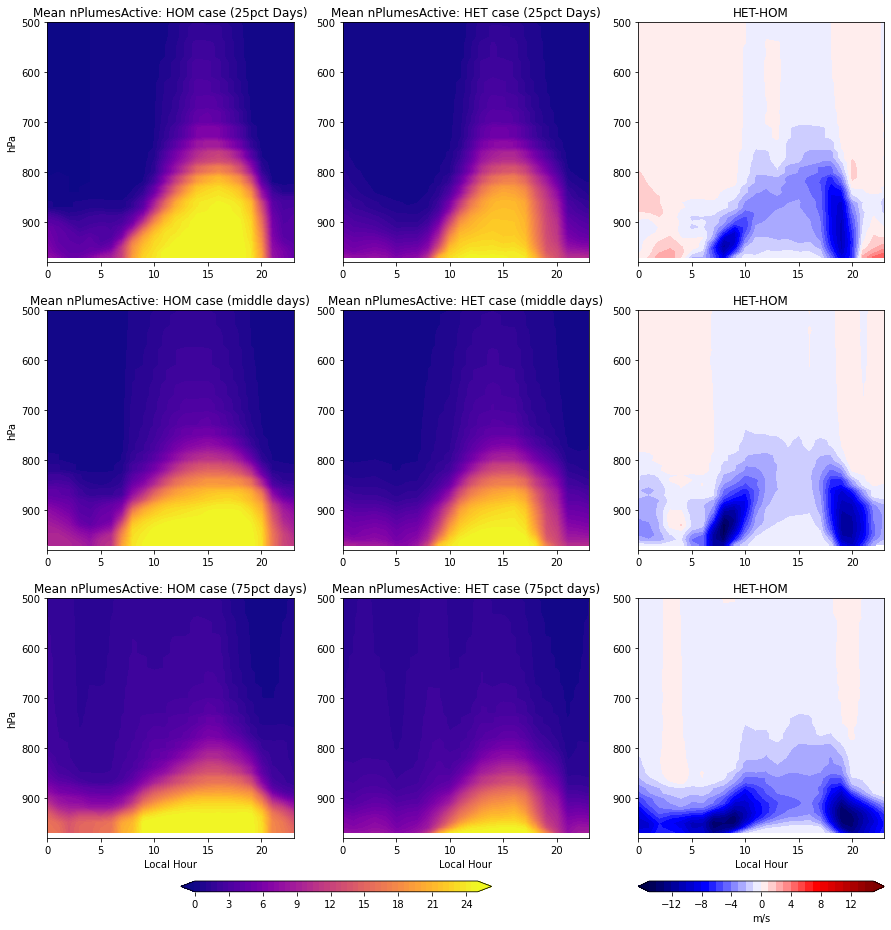

In [79]:
plotTimeHeight_h2_caseMean(clearDays_DS, otherDays_DS, cloudyDays_DS, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'nPlumesActive', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0,25.5,0.5), np.arange(-15,16,1),
                               weight=False)


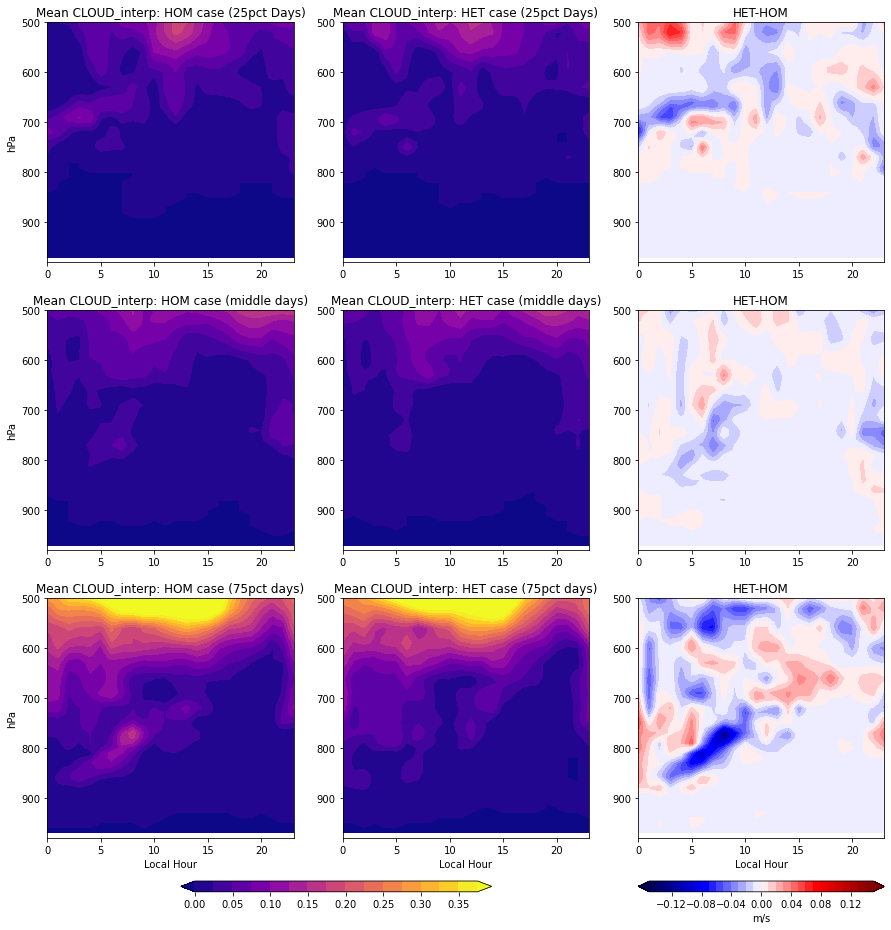

In [80]:
plotTimeHeight_h2_caseMean(clearDays_DS, otherDays_DS, cloudyDays_DS, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'CLOUD_interp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0,0.4,0.025), np.arange(-0.15,0.16,0.01),
                               weight=False)


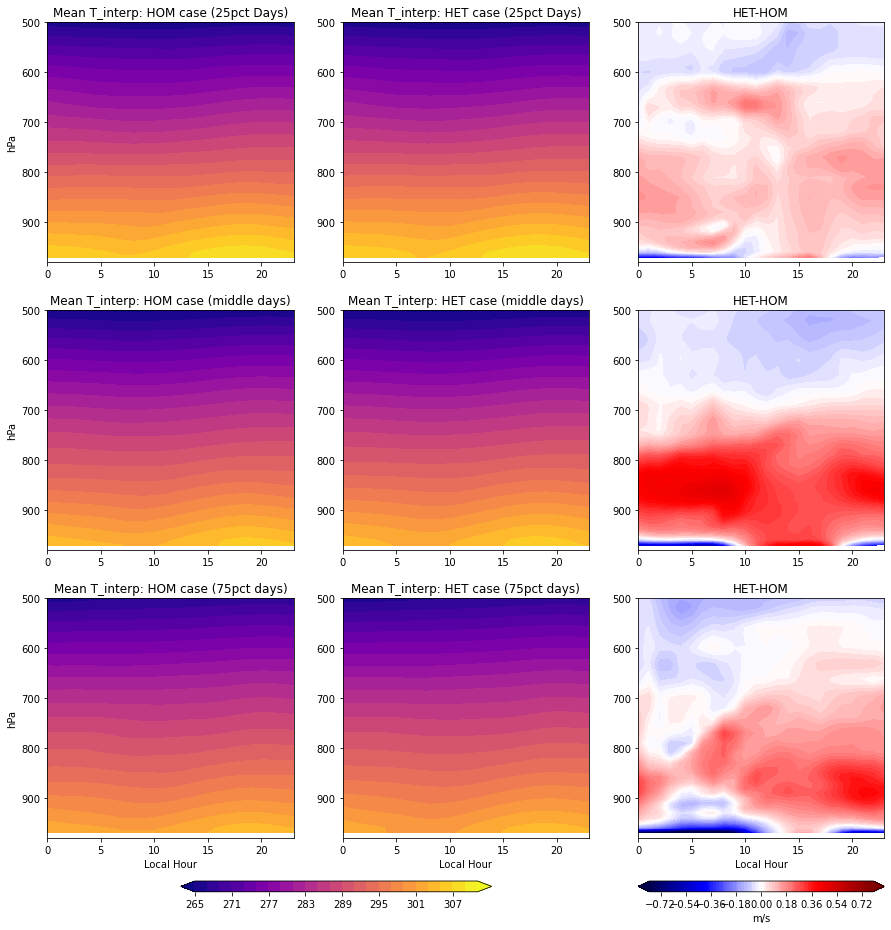

In [81]:
plotTimeHeight_h2_caseMean(clearDays_DS, otherDays_DS, cloudyDays_DS, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'T_interp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               # np.arange(265, 312, 2), np.arange(-3,3.2,0.2),
                               np.arange(265, 312, 2), np.arange(-0.8,0.82,0.02),
                               weight=False)


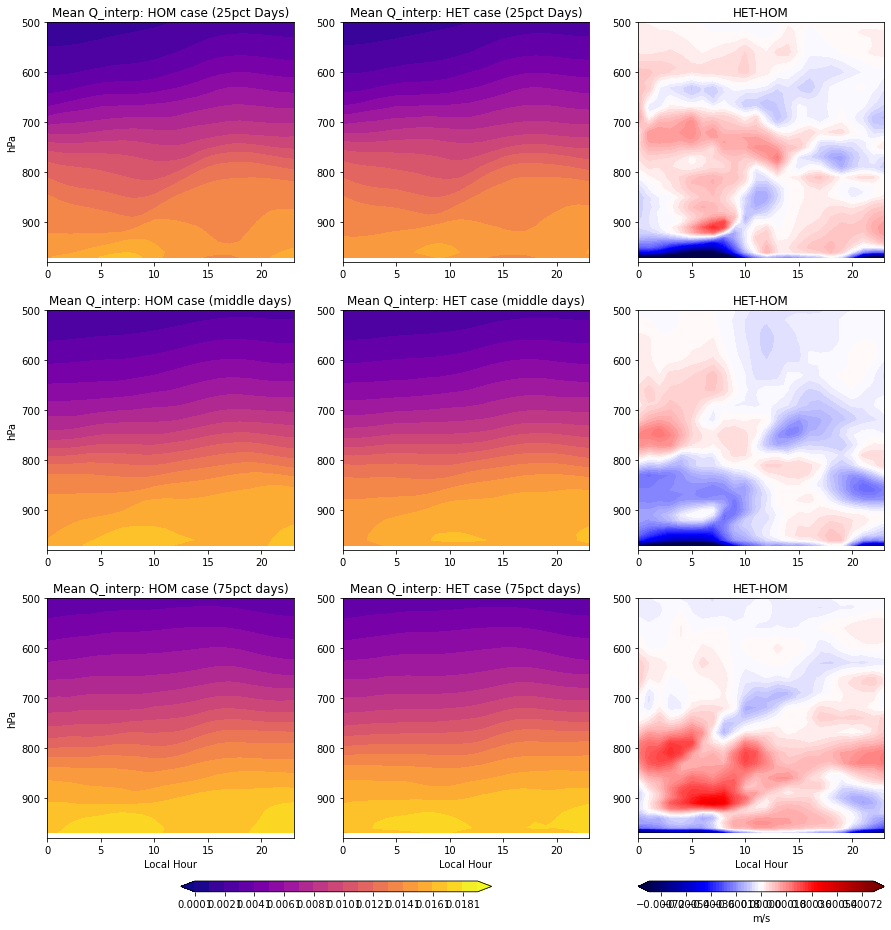

In [82]:
plotTimeHeight_h2_caseMean(clearDays_DS, otherDays_DS, cloudyDays_DS, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'Q_interp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0.1e-3, 2e-2, 1e-3), np.arange(-8e-4,8.2e-4,0.2e-4),
                               weight=False)


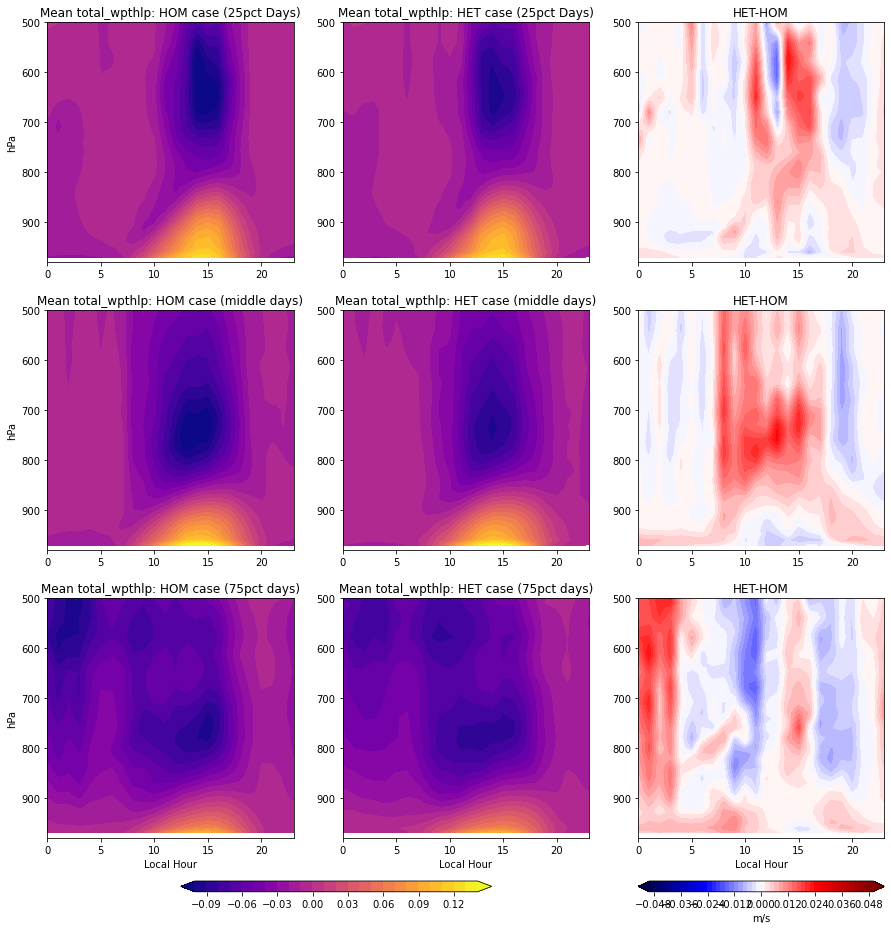

In [83]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_wpthlp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               # np.arange(-0.15,0.15,0.015), np.arange(-0.07,0.0705,0.005),
                               np.arange(-0.1,0.15,0.01), np.arange(-0.05,0.0502,0.002),
                               weight=False)

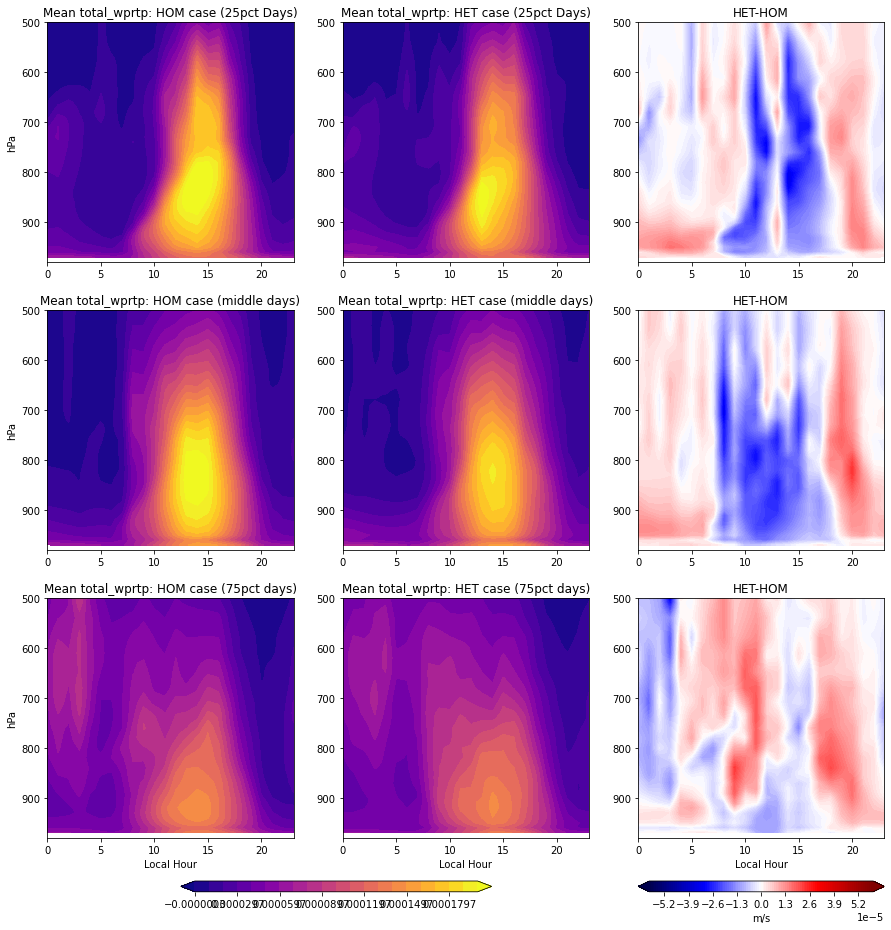

In [84]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_wprtp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(-3e-7,2e-4,1e-5), np.arange(-6.0e-5,6.1e-5,0.1e-5),
                               weight=False)

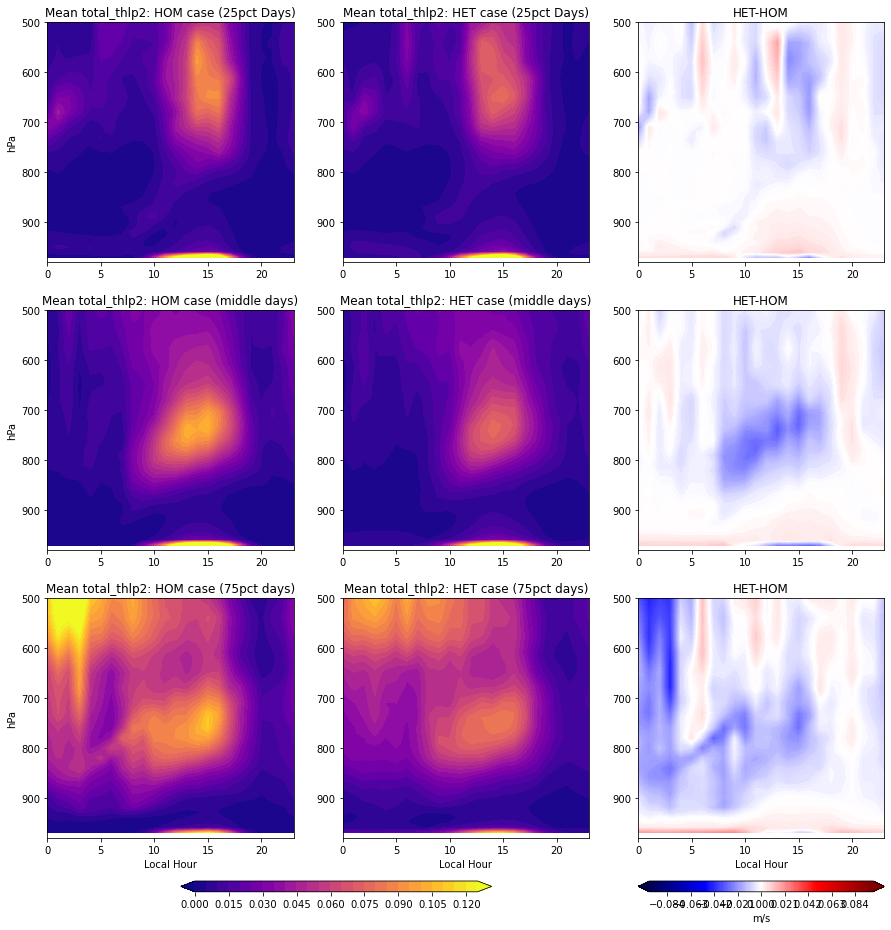

In [85]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_thlp2', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0,0.13,0.005), np.arange(-0.1,0.101,0.001),
                               weight=False)

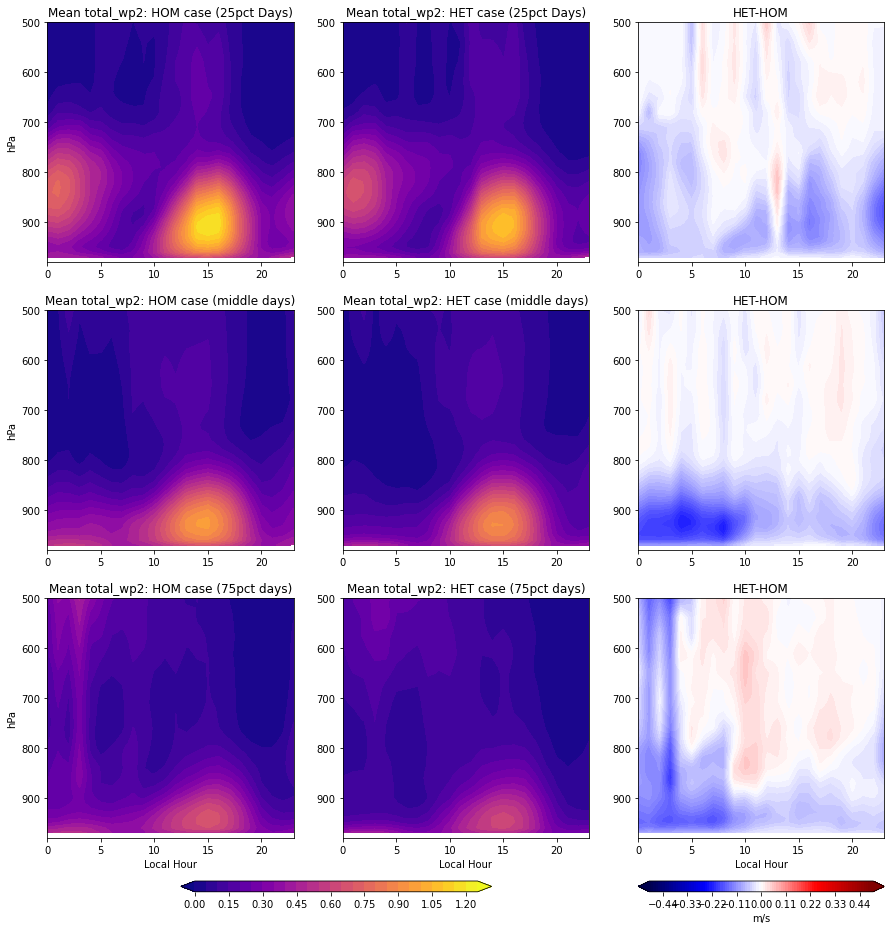

In [86]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_wp2', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0,1.3,0.05), np.arange(-0.5,0.51,0.01),
                               weight=False)

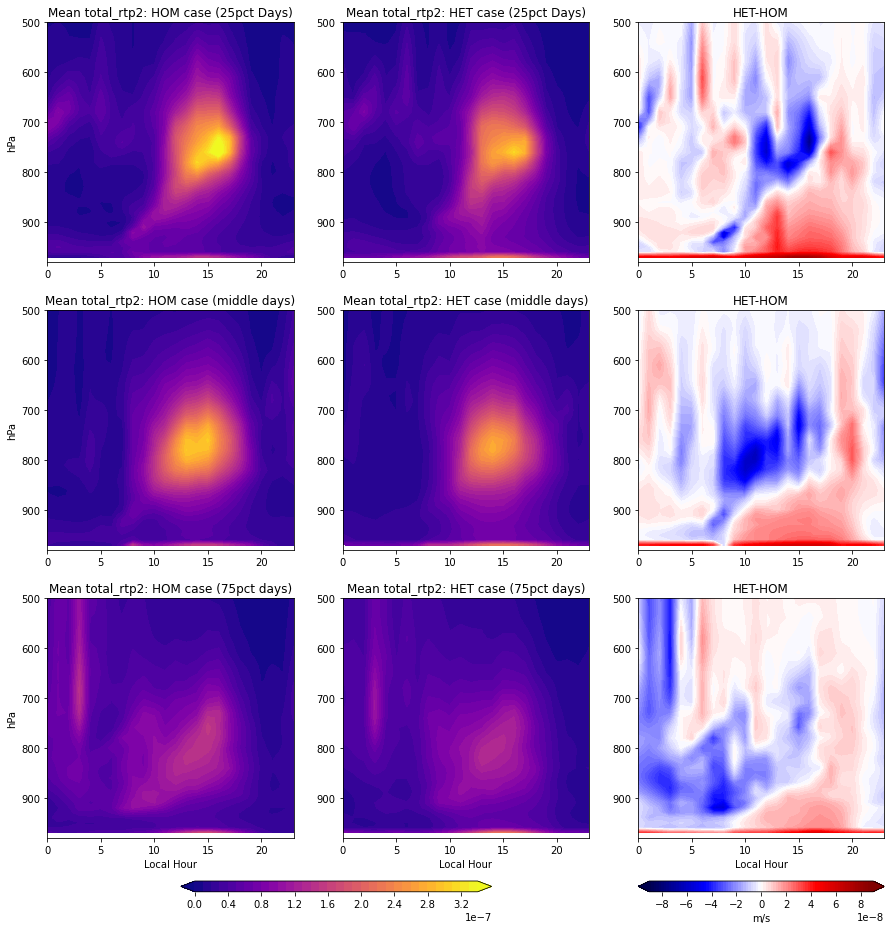

In [87]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2, 
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'total_rtp2', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(0,3.5e-7,1e-8), np.arange(-9e-8,9.2e-8,0.2e-8),
                               weight=False)

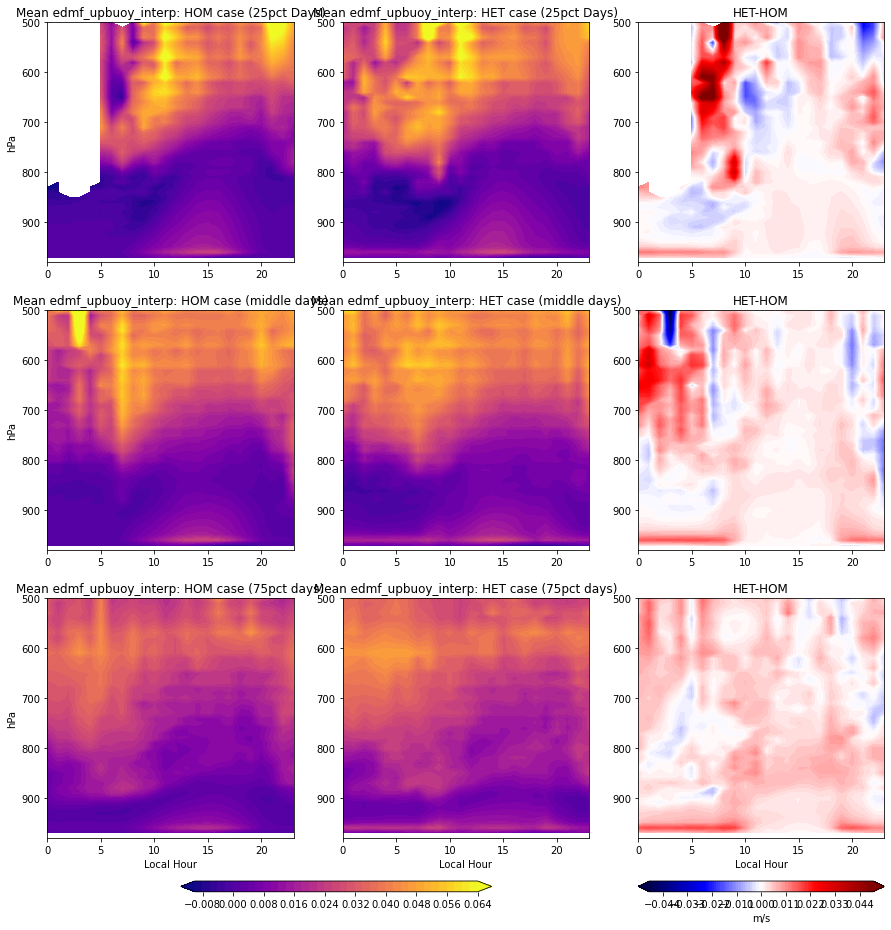

In [88]:
plotTimeHeight_h2_caseMean(clearDays_DSh2, otherDays_DSh2, cloudyDays_DSh2,
                           'clubbMF_L0eq250','claspMF_L0eq250_rand',
                               'edmf_upbuoy_interp', 
                           [' (25pct Days)', ' (middle days)', ' (75pct days)'], 
                               np.arange(-0.01,0.065,0.002), np.arange(-0.05, 0.051, 0.001),
                               # np.arange(-0.01,0.025,0.001), np.arange(-0.03, 0.031, 0.001),
                               weight=True)

Text(0.5, 1.0, 'PRECC')

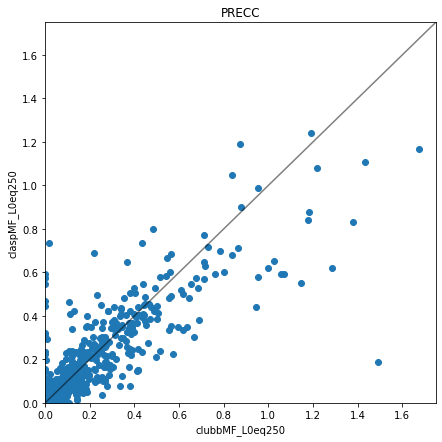

In [35]:
fig,axs = plt.subplots(1,1,figsize=(7,7))
axs.scatter(scamRain.sel(case='clubbMF_L0eq250').values, scamRain.sel(case='claspMF_L0eq250').values)
axs.plot(np.arange(0,2,0.2),np.arange(0,2,0.2),'k-',alpha=0.5 )

axs.set_xlim([0, 1.75])
axs.set_ylim([0, 1.75])

axs.set_xlabel('clubbMF_L0eq250')
axs.set_ylabel('claspMF_L0eq250')

axs.set_title('PRECC')



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


(-0.05, 1.8)

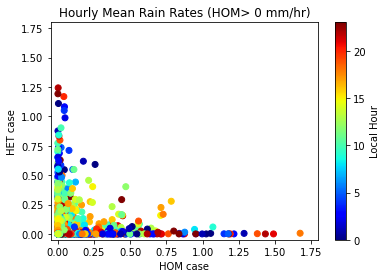

In [36]:
# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF_L0eq250').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='claspMF_L0eq250').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHMG_scam>0)[0]]  # Keep where HMG is raining

times = scamRain.sel(case='clubbMF_L0eq250')['time.hour'].values[np.where(rainRatesHMG_scam>0)[0]]
print(np.unique(times))

# for iT in range(len(rainRatesHMG_scam)):

plt.scatter(rainRatesHMG_scam, rainRatesHTG_scam,
            c=times,
            cmap = 'jet')

plt.xlabel('HOM case')
plt.ylabel('HET case')
plt.title('Hourly Mean Rain Rates (HOM> 0 mm/hr)')
plt.colorbar(label='Local Hour')
plt.xlim([-0.05,1.8])
plt.ylim([-0.05,1.8])
    

In [141]:
## Trying to follow Meng's approach for defining 'clear' days 
threshold_clear = (10**-3)*0.001  ## g/kg to kg/kg

# Based on max daytime (6a-6p) mean liquid water content below 600 hPa 
#    QT_interp = Total water mixing ratio [kg/kg]
#    CLDLIQ_interp = Grid box averaged cloud liquid amount [kg/kg]
selVar = 'CLDLIQ_interp'
print('Basing threshold on ',selVar)

selHours = np.where( (scamDS['time.hour'].values>=6) & (scamDS['time.hour'].values<=18) )[0]
scamDS_daytime = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time')

# Average for levels below 600 hPa 
var_nearSfc = scamDS_daytime[selVar].isel(levInterp=np.where(scamDS.levInterp.values>600.0)[0])
print('Size of var_nearSfc_nearSfc = ', np.shape(var_nearSfc.values))

# Get max daily value of QT 
var_dailyMax = var_nearSfc.sel(case='clubbMF_L0eq250').max(dim='levInterp')
print('Size of var_dailyMax', np.shape(var_dailyMax.values))

print('Looking into HOM case...')
print('Mean var_dailyMax: ', np.nanmean(var_dailyMax.values))
print('Max var_dailyMax: ', np.nanmax(var_dailyMax.values))
print('Min var_dailyMax: ', np.nanmin(var_dailyMax.values))

iClearDays = np.where(var_dailyMax.values<threshold_clear)[0]
print('Number of clear sky days = ', len(iClearDays))

# fig,axs = plt.subplots(1,1,figsize=(7,7))


# axs.scatter(scamDS.sel(case='clubbMF_L0eq250').isel(levInterp=np.where(scamDS.levInterp.values>600.0)[0]).QT_interp.max(dim='levInterp').values, 
#             scamDS.sel(case='clubbMF_L0eq250').CLDTOT.values)

# axs.set_xlabel('QT_interp (kg/kg)')
# axs.set_ylabel('CLDTOT (fraction)') 
# axs.set_title('How to define clear days?')

# axs.axvline(1e-3 * 0.001)



Basing threshold on  CLDLIQ_interp
Size of var_nearSfc_nearSfc =  (92, 2, 37)
Size of var_dailyMax (92,)
Looking into HOM case...
Mean var_dailyMax:  8.034438896034253e-06
Max var_dailyMax:  9.769193930231086e-05
Min var_dailyMax:  0.0
Number of clear sky days =  53


In [138]:
var_nearSfc.levInterp

<xarray.DataArray 'levInterp' (levInterp: 37)>
array([610., 620., 630., 640., 650., 660., 670., 680., 690., 700., 710., 720.,
       730., 740., 750., 760., 770., 780., 790., 800., 810., 820., 830., 840.,
       850., 860., 870., 880., 890., 900., 910., 920., 930., 940., 950., 960.,
       970.])
Coordinates:
    lat        float64 36.6
    lon        float64 262.5
  * levInterp  (levInterp) float64 610.0 620.0 630.0 640.0 ... 950.0 960.0 970.0

In [142]:
scamDS_dailyMax  = scamDS_daytime.resample(time='1D').max(dim='time')
scamDS_dailyMean = scamDS_daytime.resample(time='1D').mean(dim='time')


scamDS_hourMean = scamDS_daytime.resample(time='1H').mean(dim='time')


In [143]:
dailyMeanPRECC = scamDS_dailyMean.PRECC * (3600*1e3) ## Convert units to mm/hr



Text(0, 0.5, 'PRECC (HET-HOM)')

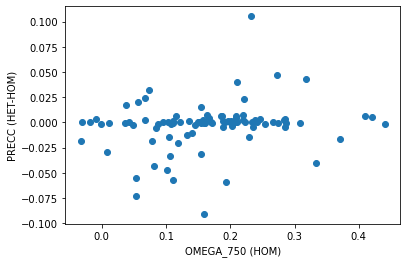

In [89]:
ctrlVar = scamDS_dailyMax.sel(case='clubbMF_L0eq250').OMEGA_interp.sel(levInterp=750.0).values

plt.scatter(ctrlVar, dailyMeanPRECC.sel(case='claspMF_L0eq250')-dailyMeanPRECC.sel(case='clubbMF_L0eq250').values)
plt.xlabel('OMEGA_750 (HOM)') 
plt.ylabel('PRECC (HET-HOM)')


In [95]:
np.shape(scamDS_midLevelOmega_max.values)

(2, 92, 21)

Text(0, 0.5, 'QREFHT (HET-HOM)')

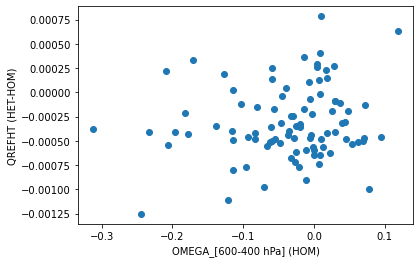

In [102]:
midLev = np.where( (scamDS_daytime.levInterp.values<=600.0) & (scamDS_daytime.levInterp.values>=400.0) )[0]

scamDS_midLevelOmega_max   = scamDS_daytime.OMEGA_interp.isel(levInterp=midLev).mean(dim='levInterp').resample(time='1D').max(dim='time')
scamDS_midLevelOmega_mean  = scamDS_daytime.OMEGA_interp.isel(levInterp=midLev).mean(dim='levInterp').resample(time='1D').mean(dim='time')


ctrlVar     = scamDS_midLevelOmega_mean.sel(case='clubbMF_L0eq250').values
responseVar = scamDS_dailyMean.sel(case='claspMF_L0eq250').QREFHT.values-scamDS_dailyMean.sel(case='clubbMF_L0eq250').QREFHT.values
# responseVar = dailyMeanPRECC.sel(case='claspMF_L0eq250')-dailyMeanPRECC.sel(case='clubbMF_L0eq250').values


plt.scatter(ctrlVar, responseVar)
plt.xlabel('OMEGA_[600-400 hPa] (HOM)') 
plt.ylabel('QREFHT (HET-HOM)')


Text(0, 0.5, 'CLDTOT (HET-HOM)')

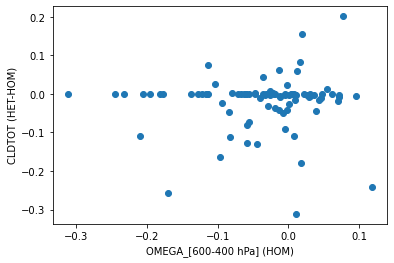

In [104]:
midLev = np.where( (scamDS_daytime.levInterp.values<=600.0) & (scamDS_daytime.levInterp.values>=400.0) )[0]

scamDS_midLevelOmega_max   = scamDS_daytime.OMEGA_interp.isel(levInterp=midLev).mean(dim='levInterp').resample(time='1D').max(dim='time')
scamDS_midLevelOmega_mean  = scamDS_daytime.OMEGA_interp.isel(levInterp=midLev).mean(dim='levInterp').resample(time='1D').mean(dim='time')


ctrlVar     = scamDS_midLevelOmega_mean.sel(case='clubbMF_L0eq250').values
responseVar = scamDS_dailyMean.sel(case='claspMF_L0eq250').CLDTOT.values-scamDS_dailyMean.sel(case='clubbMF_L0eq250').CLDTOT.values
# responseVar = dailyMeanPRECC.sel(case='claspMF_L0eq250')-dailyMeanPRECC.sel(case='clubbMF_L0eq250').values

plt.scatter(ctrlVar, responseVar)
plt.xlabel('OMEGA_[600-400 hPa] (HOM)') 
plt.ylabel('CLDTOT (HET-HOM)')


Text(0, 0.5, 'CLDTOT (HET-HOM)')

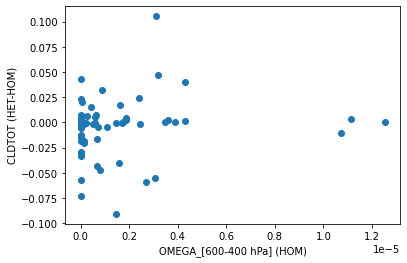

In [145]:
selHours = np.where( (scamDS['time.hour'].values>=6) & (scamDS['time.hour'].values<=18) )[0]
scamDS_daytime = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time')

# Average for levels below 600 hPa
selVar=  'CLDLIQ_interp'
var_nearSfc = scamDS_daytime[selVar].isel(levInterp=np.where(scamDS.levInterp.values>600.0)[0]).mean(dim='levInterp')

ctrlVar     = var_nearSfc.sel(case='clubbMF_L0eq250').values
# responseVar = scamDS_dailyMean.sel(case='claspMF_L0eq250').CLDTOT.values-scamDS_dailyMean.sel(case='clubbMF_L0eq250').CLDTOT.values
responseVar = dailyMeanPRECC.sel(case='claspMF_L0eq250')-dailyMeanPRECC.sel(case='clubbMF_L0eq250').values

plt.scatter(ctrlVar, responseVar)
plt.xlabel('OMEGA_[600-400 hPa] (HOM)') 
plt.ylabel('CLDTOT (HET-HOM)')




Text(0, 0.5, 'PRECC (HET-HOM)')

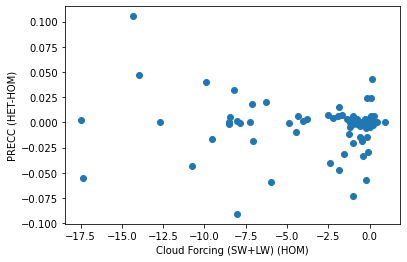

In [147]:

ctrlVar     = scamDS_dailyMean['LWCF'].sel(case='clubbMF_L0eq250').values+scamDS_dailyMean['SWCF'].sel(case='clubbMF_L0eq250').values
# responseVar = scamDS_dailyMean.sel(case='claspMF_L0eq250').CLDTOT.values-scamDS_dailyMean.sel(case='clubbMF_L0eq250').CLDTOT.values
responseVar = dailyMeanPRECC.sel(case='claspMF_L0eq250')-dailyMeanPRECC.sel(case='clubbMF_L0eq250').values

plt.scatter(ctrlVar, responseVar)
plt.xlabel('Cloud Forcing (SW+LW) (HOM)') 
plt.ylabel('PRECC (HET-HOM)')



Text(0, 0.5, 'PRECC (HET-HOM)')

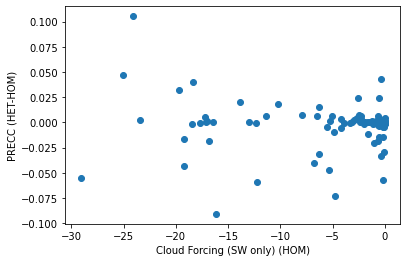

In [150]:

ctrlVar     = scamDS_dailyMean['SWCF'].sel(case='clubbMF_L0eq250').values
# responseVar = scamDS_dailyMean.sel(case='claspMF_L0eq250').CLDTOT.values-scamDS_dailyMean.sel(case='clubbMF_L0eq250').CLDTOT.values
responseVar = dailyMeanPRECC.sel(case='claspMF_L0eq250')-dailyMeanPRECC.sel(case='clubbMF_L0eq250').values

plt.scatter(ctrlVar, responseVar)
plt.xlabel('Cloud Forcing (SW only) (HOM)') 
plt.ylabel('PRECC (HET-HOM)')

